In [1]:
import pandas as pd
import locale
import glob
import chardet
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load data

In [3]:
def read_data_per_file(file: str) -> pd.DataFrame:
    """
    Reads data from a CSV file and returns it as a pandas DataFrame. Handles skipping rows

    Args:
        file (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Detect the encoding
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    data =  pd.read_csv(file, encoding=encoding, skiprows=2)
        
    return data

In [4]:
def load_visitor_counts_data(
    data_folder: str,
) -> pd.DataFrame:
    """
    Loads visitor counts data from multiple CSV files in the specified folder and deletes some unnecessary column.

    Args:
        data_folder (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: The DataFrame containing the visitor counts data.
    """
    # Read data from CSV files

    raw_visitor_counts = pd.concat([read_data_per_file(
        file
    ) for file in glob.glob(f"{data_folder}/*.csv")])
    
    # Drop last empty column
    visitor_counts = raw_visitor_counts.drop(columns=["Unnamed: 96"])

    return visitor_counts

visitor_counts = load_visitor_counts_data(data_folder="data")

# Preprocess data

In [5]:
# Check the data type of the 'Time' column
print(visitor_counts['Time'].dtype)

object


In [6]:
# Convert the 'Time' column to string if it's not already
visitor_counts['Time'] = visitor_counts['Time'].astype(str)

In [7]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

         # Set the date column as the index
    df.set_index(date_column_name, inplace=True)

    return df

visitor_counts_parsed_dates = parse_german_dates(df=visitor_counts, date_column_name="Time")

# Saving the Aggregated DataFrame to CSV

In [ ]:
visitor_counts_parsed_dates.columns[-1]

In [8]:
# Define the folder path
folder_path = "data/visitor_count"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")

In [10]:
# Define the full path to save the CSV file in the 'visitor_count' subfolder
output_path = os.path.join(folder_path, "aggregated_historic_visitor_count.csv")

# Save the aggregated and parsed data to the specified CSV file
visitor_counts_parsed_dates.to_csv(output_path, sep=',', encoding='utf-8', index=True)

# Print a confirmation message
print(f"Data saved to '{output_path}'")

Data saved to 'data/visitor_count\aggregated_historic_visitor_count.csv'


Data Exploration


In [167]:
visitor_counts = visitor_counts_parsed_dates

In [168]:
# Checking if there are any missing values in the index
missing_index = visitor_counts.index.isnull().sum()
print(f"Number of missing values in the index: {missing_index}")

# Check for missing values (NaT) in the index
missing_in_index = visitor_counts.index.isna().sum()

print(f"Missing (NaT) values in the index: {missing_in_index}")

Number of missing values in the index: 8760
Missing (NaT) values in the index: 8760


Exploratory Data Analysis 

Resample the Data by Year

In [169]:
# Resample the data to yearly frequency and sum the counts
yearly_data = visitor_counts.resample('Y').sum()

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\3733596179.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = visitor_counts.resample('Y').sum()


Calculate Yearly Totals

In [170]:
# Calculate the total visitors per year across all sensors
yearly_data['Total_Visitors'] = yearly_data.sum(axis=1)

# Display the yearly total visitors
print(yearly_data['Total_Visitors'])


Time
2018-12-31     585362.0
2019-12-31     711168.0
2020-12-31     926212.0
2021-12-31     985854.0
2022-12-31    1218797.0
2023-12-31    1618783.0
Name: Total_Visitors, dtype: object


Visualize Yearly Trends

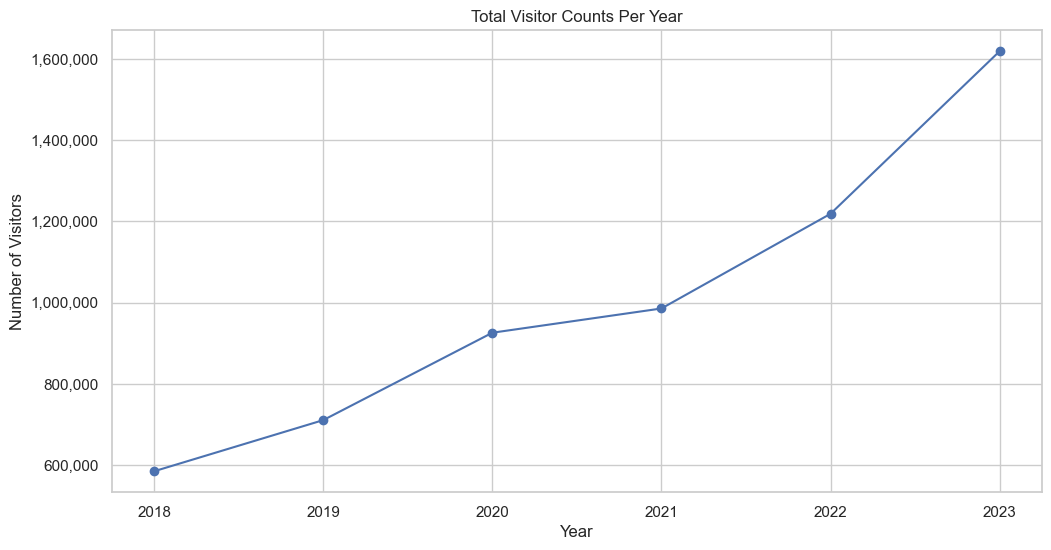

In [171]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define a function to format the y-axis labels
def format_thousands(x, pos):
    'The two args are the value and tick position'
    return f'{int(x):,}'

# Plot the total visitors per year
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index.year, yearly_data['Total_Visitors'], marker='o', linestyle='-', color='b')

# Set title and labels
plt.title('Total Visitor Counts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Visitors')

# Format the y-axis with thousands separator
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ensure all years are shown on x-axis
plt.xticks(yearly_data.index.year)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


Analyze Yearly Growth Rates

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\1805097645.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100
posx and posy should be finite values


Time
2018-12-31          NaN
2019-12-31    21.492000
2020-12-31    30.238143
2021-12-31     6.439346
2022-12-31    23.628549
2023-12-31    32.818099
Name: Yearly_Growth_Rate, dtype: float64


posx and posy should be finite values


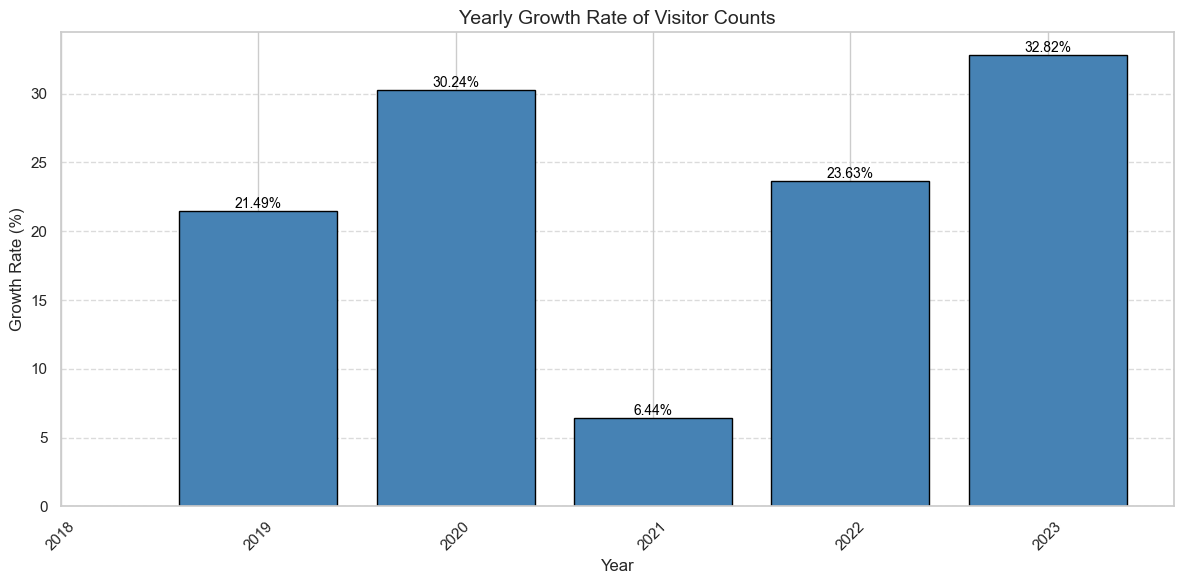

In [172]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the year-over-year percentage change
yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100

# Display the growth rates (for verification)
print(yearly_data['Yearly_Growth_Rate'])

# Plot the growth rates
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_data.index.year, yearly_data['Yearly_Growth_Rate'], color='steelblue', edgecolor='black')

# Add annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title('Yearly Growth Rate of Visitor Counts', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_data.index.year, rotation=45)  # Rotate x-ticks for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Suppress FutureWarning
pd.options.mode.chained_assignment = None


Monthly Trends

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\861781136.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = visitor_counts_parsed_dates.resample('M').sum()


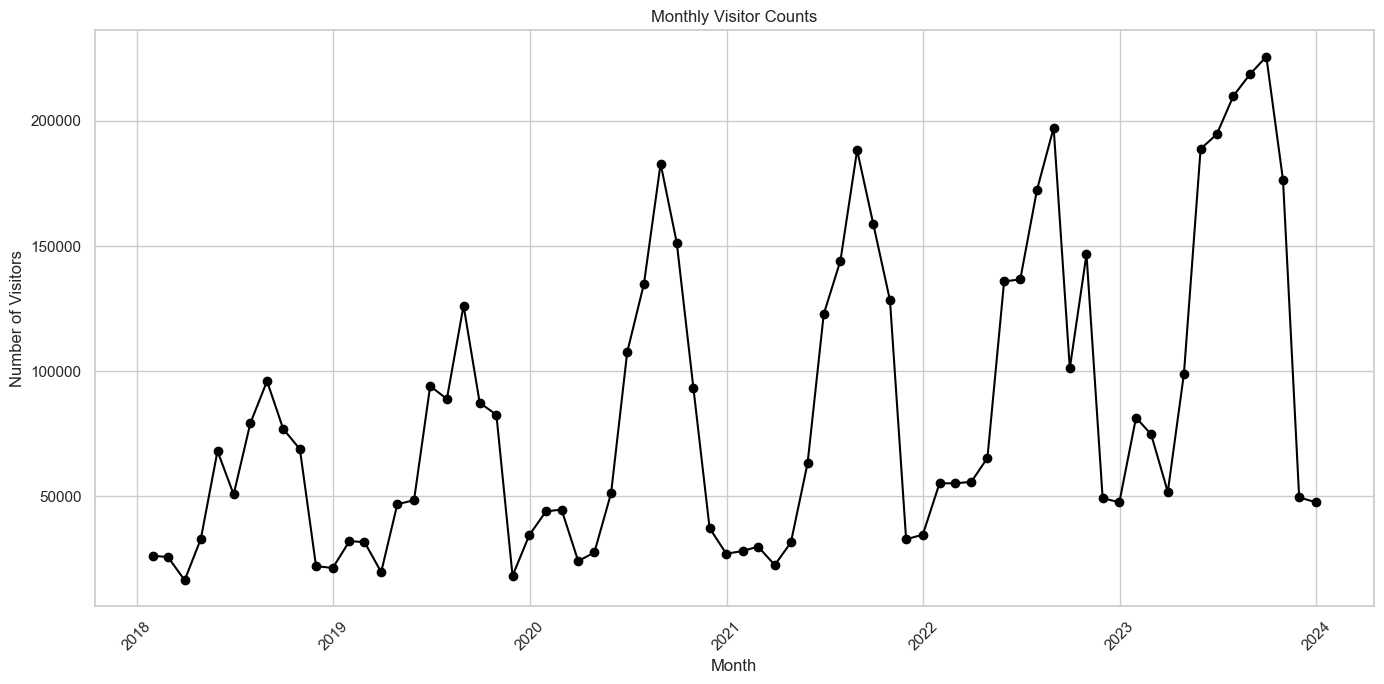

In [173]:
# Resample the data to a monthly frequency and sum the counts
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

# Calculate monthly totals
monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Plot monthly trends
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], marker='o', linestyle='-', color='black')
plt.title('Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


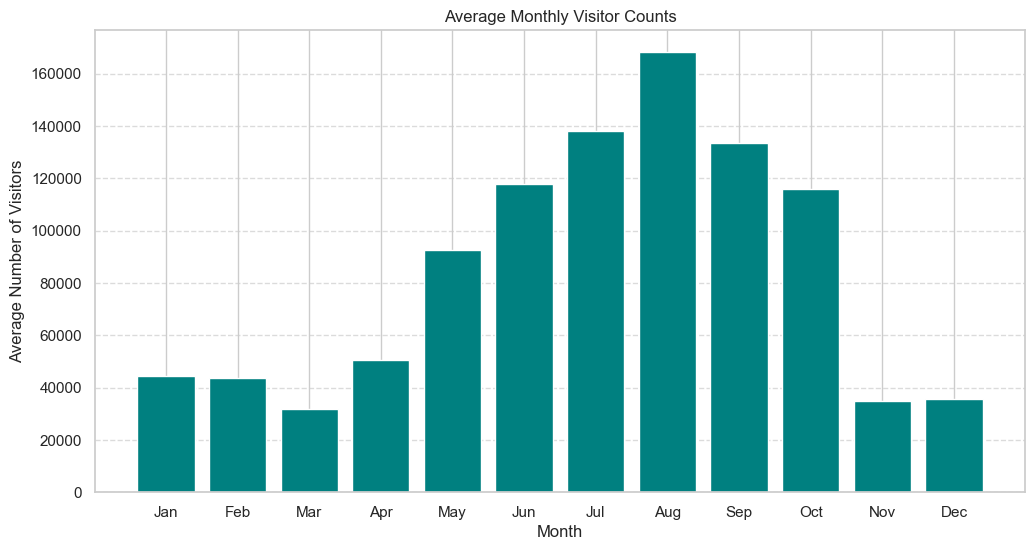

In [174]:
# Aggregate monthly data by year to find seasonal patterns
seasonal_data = monthly_data.groupby(monthly_data.index.month).mean()

# Plot average monthly visitor counts
plt.figure(figsize=(12, 6))
plt.bar(seasonal_data.index, seasonal_data['Total_Visitors'], color='teal')
plt.title('Average Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


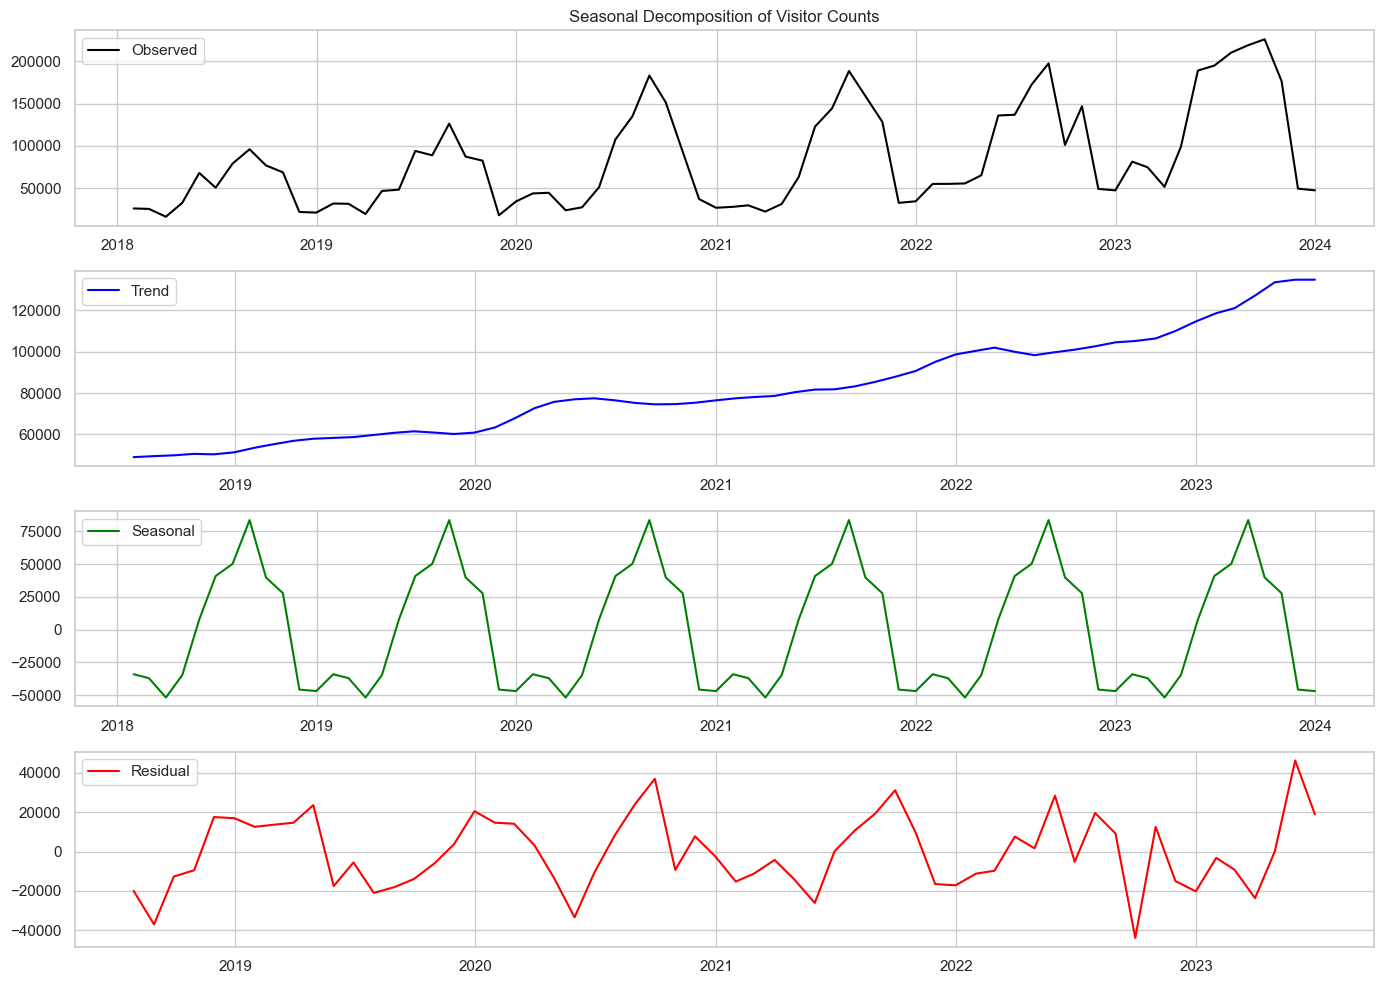

In [175]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_data['Total_Visitors'], model='additive')

# Plot the decomposition components
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='black')
plt.legend()
plt.title('Seasonal Decomposition of Visitor Counts')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()
    

Summary of the above stat:

Observed: Your raw visitor data.

Trend: Long-term direction in visitor counts.

Seasonal: Periodic fluctuations or seasonal patterns.

Residual: Random noise or irregular deviations

Sensors Overview

In [176]:
visitor_counts.columns

Index(['Bayerisch Eisenstein IN', 'Bayerisch Eisenstein OUT',
       'Bayerisch Eisenstein Fußgänger IN',
       'Bayerisch Eisenstein Fußgänger OUT',
       'Bayerisch Eisenstein Fahrräder IN',
       'Bayerisch Eisenstein Fahrräder OUT', 'Brechhäuslau IN',
       'Brechhäuslau OUT', 'Brechhäuslau Fußgänger IN',
       'Brechhäuslau Fußgänger OUT', 'Bucina IN', 'Bucina OUT',
       'Bucina_Multi OUT', 'Bucina_Multi Fußgänger IN',
       'Bucina_Multi Fahrräder IN', 'Bucina_Multi Fahrräder OUT',
       'Bucina_Multi Fußgänger OUT', 'Deffernik IN', 'Deffernik OUT',
       'Deffernik Fahrräder IN', 'Deffernik Fahrräder OUT',
       'Deffernik Fußgänger IN', 'Deffernik Fußgänger OUT',
       'Diensthüttenstraße Fußgänger IN', 'Diensthüttenstraße Fußgänger OUT',
       'Felswandergebiet IN', 'Felswandergebiet OUT', 'Ferdinandsthal IN',
       'Ferdinandsthal OUT', 'Fredenbrücke Fußgänger IN',
       'Fredenbrücke Fußgänger OUT', 'Gfäll Fußgänger IN',
       'Gfäll Fußgänger OUT', 'Gsenget 

In [177]:
# Identify columns related to pedestrians and bicycles
pedestrian_columns = [col for col in visitor_counts_parsed_dates.columns if 'Fußgänger IN' in col]
bicycle_columns = [col for col in visitor_counts_parsed_dates.columns if 'Fahrräder IN' in col]

# Separate the data for pedestrians and bicycles
pedestrian_data = visitor_counts_parsed_dates[pedestrian_columns]
bicycle_data = visitor_counts_parsed_dates[bicycle_columns]

print(f"Total pedestrian sensors: {len(pedestrian_columns)}")
print(f"Total bicycle sensors: {len(bicycle_columns)}")


Total pedestrian sensors: 13
Total bicycle sensors: 8


In [178]:
# Sum up pedestrian and bicycle counts across all sensors
pedestrian_data['Total_Pedestrians'] = pedestrian_data.sum(axis=1)
bicycle_data['Total_Bicycles'] = bicycle_data.sum(axis=1)

# Calculate daily averages
daily_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('D').mean()
daily_avg_bicycles = bicycle_data['Total_Bicycles'].resample('D').mean()

# Calculate monthly averages
monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('ME').mean()
monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('ME').mean()

# Display the results
print(f"Average daily pedestrians: {daily_avg_pedestrians.mean()}")
print(f"Average daily bicycles: {daily_avg_bicycles.mean()}")


Average daily pedestrians: 15.659535219838736
Average daily bicycles: 2.061216339570972


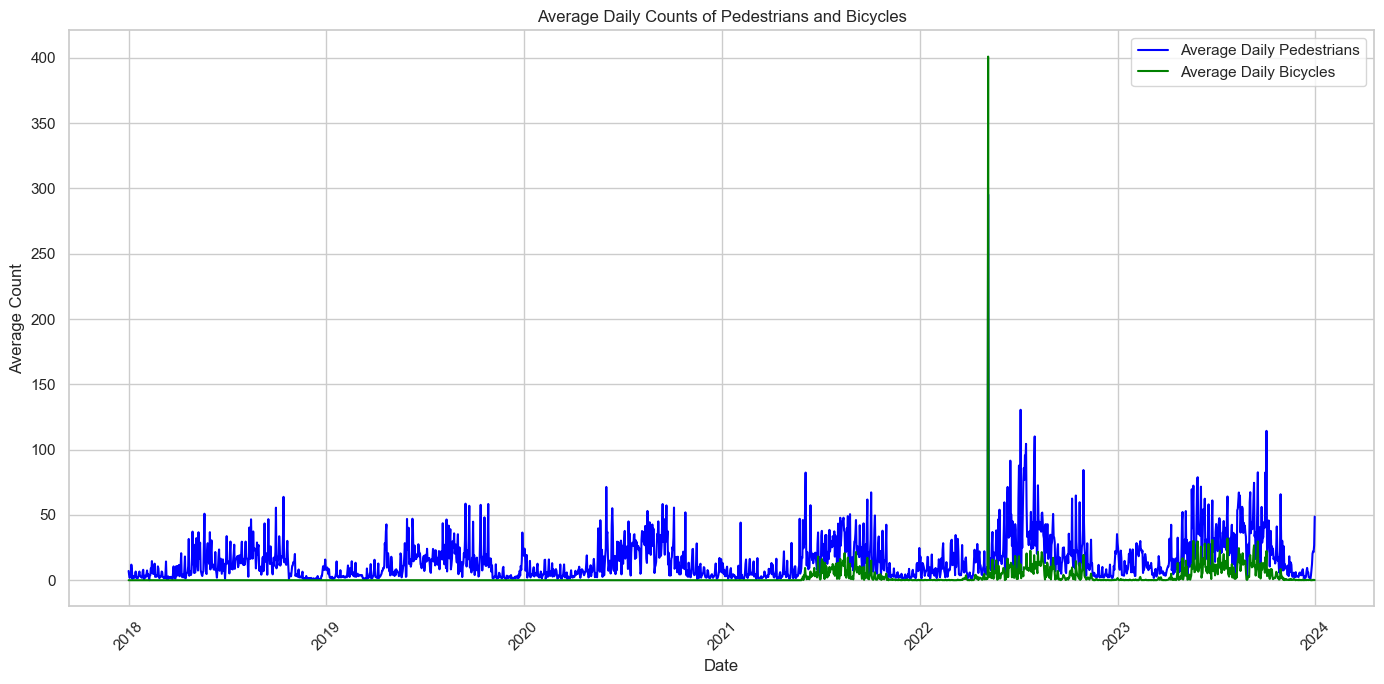

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(daily_avg_pedestrians.index, daily_avg_pedestrians, label='Average Daily Pedestrians', color='blue')
plt.plot(daily_avg_bicycles.index, daily_avg_bicycles, label='Average Daily Bicycles', color='green')
plt.title('Average Daily Counts of Pedestrians and Bicycles')
plt.xlabel('Date')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\4105169468.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('M').mean()
C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\4105169468.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('M').mean()


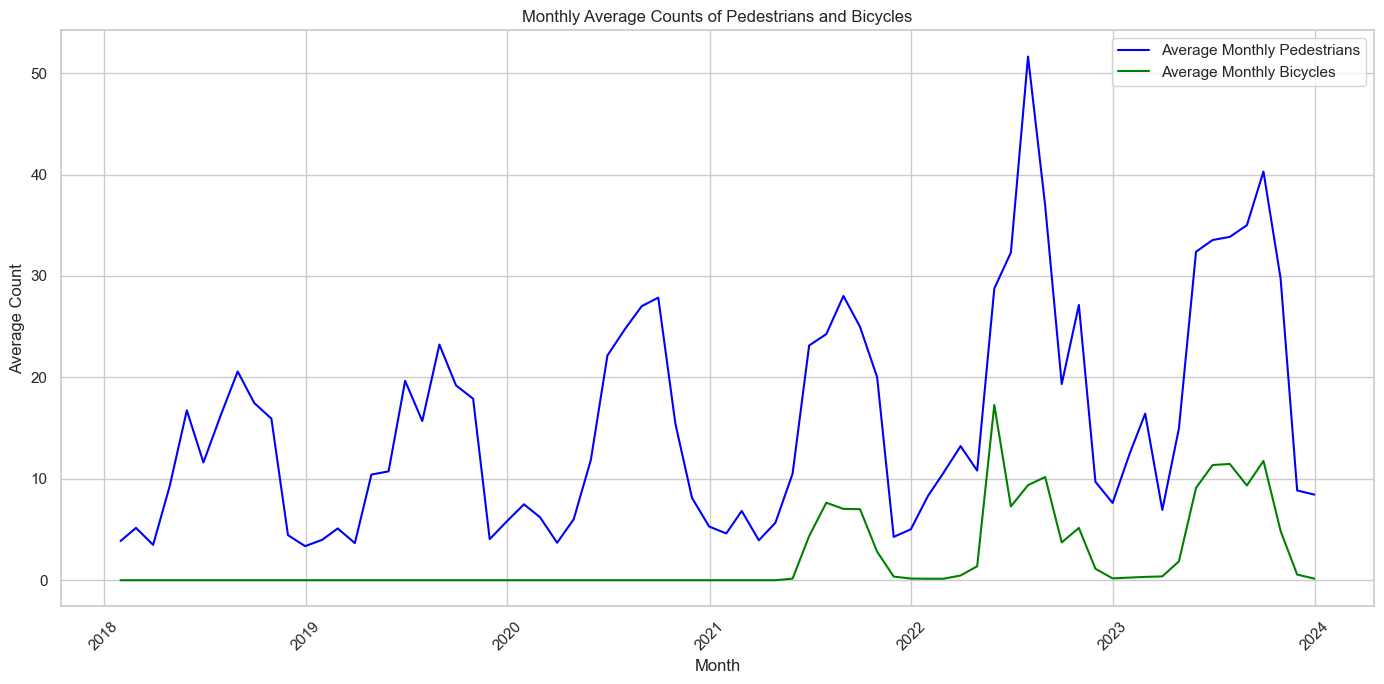

In [180]:
# Plot monthly averages
monthly_avg_pedestrians = pedestrian_data['Total_Pedestrians'].resample('M').mean()
monthly_avg_bicycles = bicycle_data['Total_Bicycles'].resample('M').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg_pedestrians.index, monthly_avg_pedestrians, label='Average Monthly Pedestrians', color='blue')
plt.plot(monthly_avg_bicycles.index, monthly_avg_bicycles, label='Average Monthly Bicycles', color='green')
plt.title('Monthly Average Counts of Pedestrians and Bicycles')
plt.xlabel('Month')
plt.ylabel('Average Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


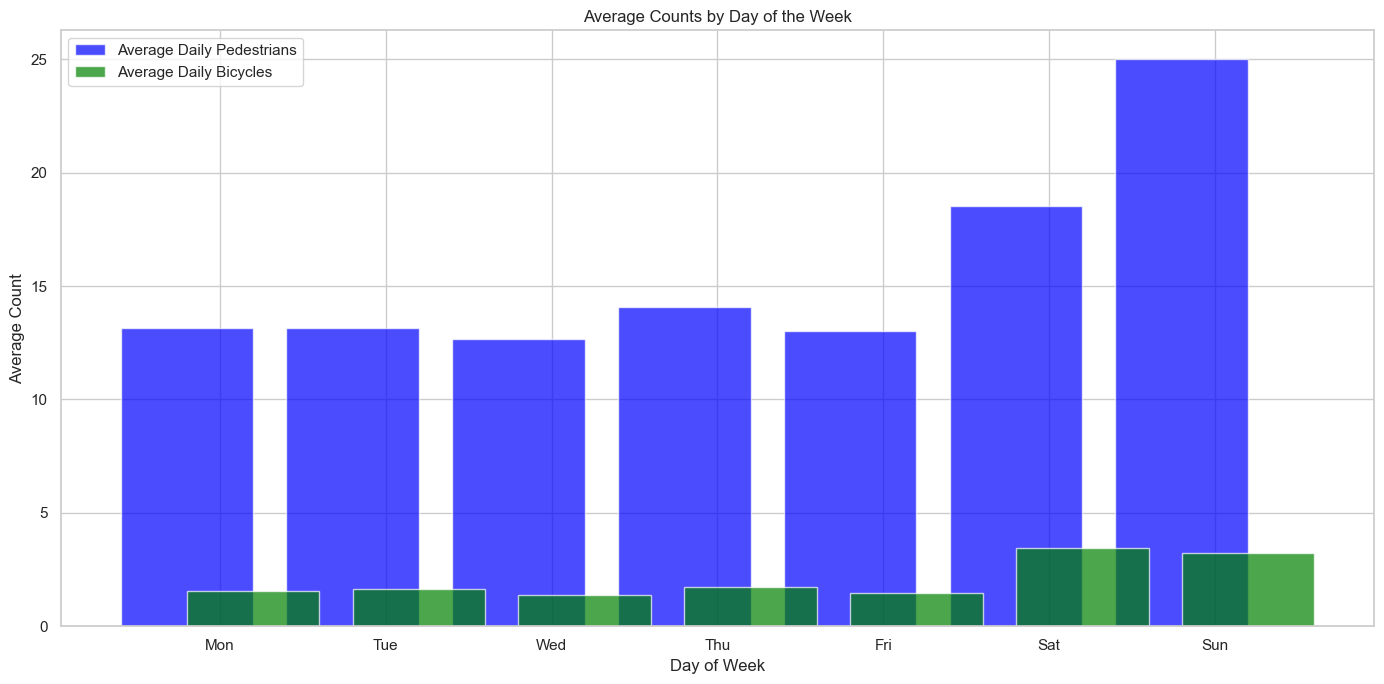

In [181]:
# Extract day of week and calculate average counts
pedestrian_data['Day_of_Week'] = pedestrian_data.index.dayofweek
bicycle_data['Day_of_Week'] = bicycle_data.index.dayofweek

daily_avg_weekday_pedestrians = pedestrian_data.groupby('Day_of_Week')['Total_Pedestrians'].mean()
daily_avg_weekday_bicycles = bicycle_data.groupby('Day_of_Week')['Total_Bicycles'].mean()

# Plot day of week averages
plt.figure(figsize=(14, 7))
plt.bar(daily_avg_weekday_pedestrians.index, daily_avg_weekday_pedestrians, label='Average Daily Pedestrians', color='blue', alpha=0.7)
plt.bar(daily_avg_weekday_bicycles.index + 0.4, daily_avg_weekday_bicycles, label='Average Daily Bicycles', color='green', alpha=0.7)
plt.title('Average Counts by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Count')
plt.xticks(ticks=daily_avg_weekday_pedestrians.index + 0.2, labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Forecasting and Predictive Analysis

SARIMA Model for Visitor Count Forecasting


The Seasonal ARIMA (SARIMA) model is an extension of the ARIMA model used for time series forecasting, particularly effective for data with seasonal patterns. In our case, where visitor counts show trends and seasonal variations (e.g., more visitors in summer), SARIMA helps us capture both the overall trend and the seasonality.

Implementation:

Data Preparation: Resampled the data to monthly totals to focus on seasonal trends.

Model Definition: Specified SARIMA parameters that reflect both the short-term and seasonal dependencies in the data.

Model Fitting: The model is trained on historical data to understand underlying patterns.

Forecasting: The trained model is used to predict future visitor counts, giving insights into expected trends.

In [182]:
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\1732069065.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = visitor_counts_parsed_dates.resample('M').sum()


C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\428634982.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]


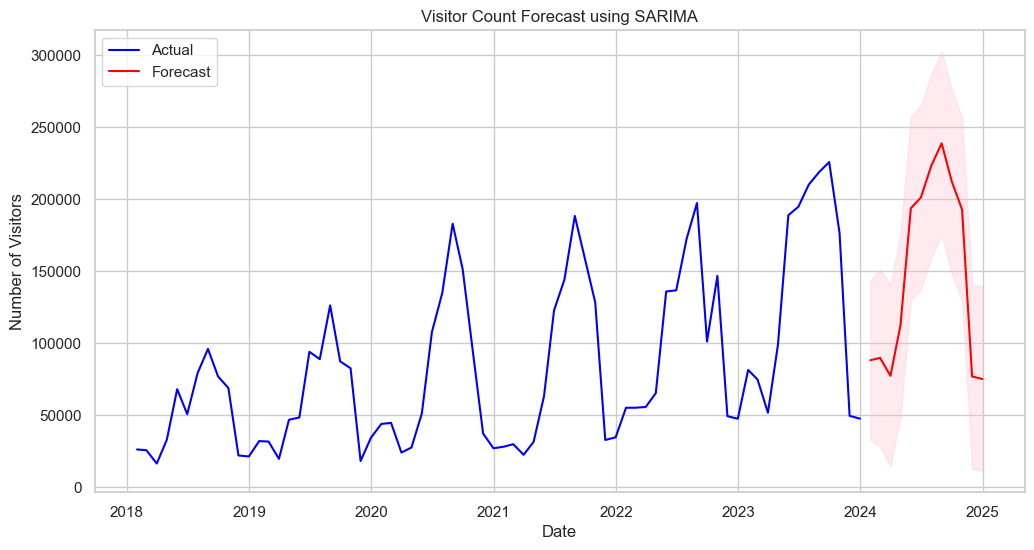

In [183]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Check if 'Total_Visitors' needs to be created by summing across all columns
if 'Total_Visitors' not in monthly_data.columns:
    monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Convert 'Total_Visitors' to numeric, forcing any non-numeric values to NaN
monthly_data['Total_Visitors'] = pd.to_numeric(monthly_data['Total_Visitors'], errors='coerce')

# Drop any rows with NaN values that might have been created during conversion
monthly_data.dropna(subset=['Total_Visitors'], inplace=True)

# Ensure the index is a DateTimeIndex with a frequency set
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data = monthly_data.asfreq('ME')

# Define the SARIMA model
model = SARIMAX(monthly_data['Total_Visitors'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit()

# Forecast the next 12 months
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the actual data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], label='Actual', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_series.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Visitor Count Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.show()


## Data Filtering and Selection

###  Filter Unnecessary Columns
- Filtering out columns with keywords `'OUT'`, `'Fußgänger'`, `'Pedestrian'` and `'Fahrräder'`.


In [184]:
# Filter out columns with specific keywords
columns_to_exclude = [col for col in visitor_counts.columns if 
                      'OUT' in col or 
                      'Fußgänger' in col or 
                      'Fahrräder' in col or
                      'Pedestrian' in col]

# Drop the identified columns
filtered_visitor_counts = visitor_counts.drop(columns=columns_to_exclude)

# Display the filtered DataFrame's columns
print("Columns after filtering:")
print(filtered_visitor_counts.columns)

Columns after filtering:
Index(['Bayerisch Eisenstein IN', 'Brechhäuslau IN', 'Bucina IN',
       'Deffernik IN', 'Felswandergebiet IN', 'Ferdinandsthal IN',
       'Gsenget IN', 'Gsenget IN.1', 'Klingenbrunner Wald IN',
       'Klosterfilz IN', 'NPZ_Falkenstein IN', 'Racheldiensthütte IN',
       'Scheuereck IN', 'Schillerstraße IN', 'TFG_Lusen IN',
       'TFG_Lusen_3 TFG Lusen 3 IN', 'Trinkwassertalsperre IN',
       'Trinkwassertalsperre_MULTI IN', 'Waldhausreibe IN',
       'Waldhausreibe Channel 1 IN', 'Waldspielgelände_1 IN'],
      dtype='object')


###  Add Specific Columns
- Adding missing columns to the filtered DataFrame.

In [185]:
# List of columns you want to add to the final DataFrame
columns_to_add = [
    'Diensthüttenstraße Fußgänger IN', 
    'Gfäll Fußgänger IN', 
    'Sagwassersäge Fußgänger IN', 
    'Schwarzbachbrücke Fußgänger IN', 
    'TFG_Falkenstein_1 Fußgänger zum Parkplatz',
    'TFG_Falkenstein_2 Fußgänger In Richtung TFG',
    'TFG_Lusen_1 Fußgänger Richtung TFG', 
    'TFG_Lusen_1 Fußgänger Richtung Parkplatz',
    'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand', 
    'TFG_Lusen_2 Fußgänger Richtung Parkplatz'
]

# Filter the columns that exist in the original DataFrame
columns_to_add = [col for col in columns_to_add if col in visitor_counts.columns]

# Add the missing columns to the filtered DataFrame
final_visitor_counts = pd.concat([filtered_visitor_counts, visitor_counts[columns_to_add]], axis=1)

# Display the columns in the final DataFrame
print("Columns in the final DataFrame:")
print(final_visitor_counts.columns)


Columns in the final DataFrame:
Index(['Bayerisch Eisenstein IN', 'Brechhäuslau IN', 'Bucina IN',
       'Deffernik IN', 'Felswandergebiet IN', 'Ferdinandsthal IN',
       'Gsenget IN', 'Gsenget IN.1', 'Klingenbrunner Wald IN',
       'Klosterfilz IN', 'NPZ_Falkenstein IN', 'Racheldiensthütte IN',
       'Scheuereck IN', 'Schillerstraße IN', 'TFG_Lusen IN',
       'TFG_Lusen_3 TFG Lusen 3 IN', 'Trinkwassertalsperre IN',
       'Trinkwassertalsperre_MULTI IN', 'Waldhausreibe IN',
       'Waldhausreibe Channel 1 IN', 'Waldspielgelände_1 IN',
       'Diensthüttenstraße Fußgänger IN', 'Gfäll Fußgänger IN',
       'Sagwassersäge Fußgänger IN', 'Schwarzbachbrücke Fußgänger IN',
       'TFG_Falkenstein_1 Fußgänger zum Parkplatz',
       'TFG_Falkenstein_2 Fußgänger In Richtung TFG',
       'TFG_Lusen_1 Fußgänger Richtung TFG',
       'TFG_Lusen_1 Fußgänger Richtung Parkplatz',
       'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand',
       'TFG_Lusen_2 Fußgänger Richtung Parkplatz'],
      

##  Exploratory Data Analysis (EDA)

###  Yearly Analysis
- Aggregating visitor counts by year.
- Visualizing the yearly visitor trends and growth rates.

In [186]:
# Resample the data to yearly frequency and sum the counts
yearly_data = final_visitor_counts.resample('Y').sum()

# Display the first few rows of the yearly data to verify
print("Yearly Aggregated Visitor Counts:")
print(yearly_data.head())


Yearly Aggregated Visitor Counts:
            Bayerisch Eisenstein IN  Brechhäuslau IN  Bucina IN  Deffernik IN  \
Time                                                                            
2018-12-31                      0.0          68716.0    40404.0           0.0   
2019-12-31                      0.0          74213.0    39056.0           0.0   
2020-12-31                      0.0          60369.0    40237.0           0.0   
2021-12-31                      0.0          49064.0     2736.0       16475.0   
2022-12-31                   2546.0          53302.0        0.0       26022.0   

            Felswandergebiet IN  Ferdinandsthal IN  Gsenget IN  Gsenget IN.1  \
Time                                                                           
2018-12-31               9859.0            12265.0      6372.0        6372.0   
2019-12-31              10782.0            15909.0      5654.0        5654.0   
2020-12-31              16549.0            14231.0         0.0           0.0  

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\1843390721.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_data = final_visitor_counts.resample('Y').sum()


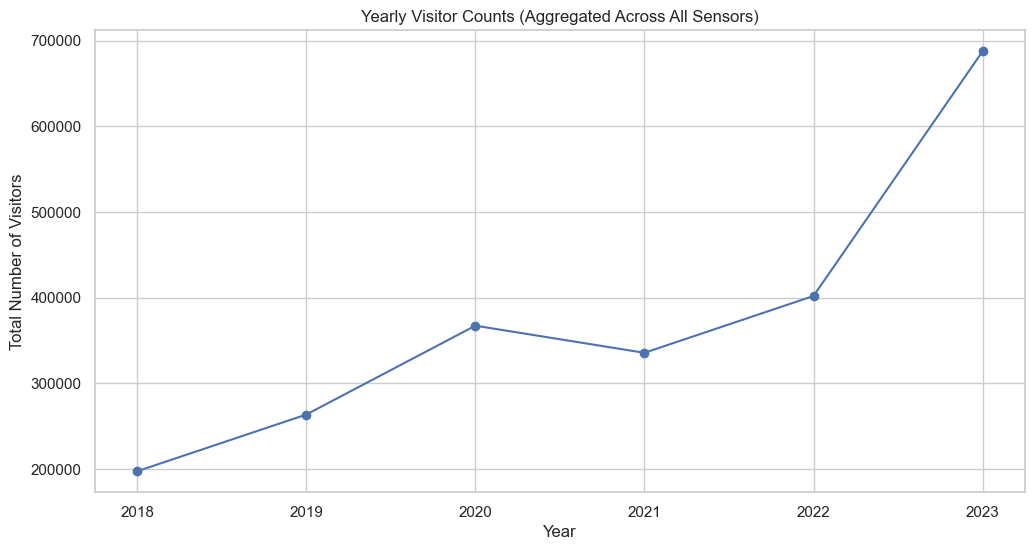

In [187]:
import matplotlib.pyplot as plt

# Plot the yearly visitor counts
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index.year, yearly_data.sum(axis=1), marker='o', color='b')
plt.title('Yearly Visitor Counts (Aggregated Across All Sensors)')
plt.xlabel('Year')
plt.ylabel('Total Number of Visitors')
plt.grid(True)
plt.xticks(yearly_data.index.year)  # Ensure all years are shown on x-axis
plt.show()


Yearly Growth Rates:
Time
2018-12-31          NaN
2019-12-31    33.533362
2020-12-31    39.368728
2021-12-31    -8.618107
2022-12-31    19.765040
2023-12-31    71.076075
Name: Yearly_Growth_Rate, dtype: float64


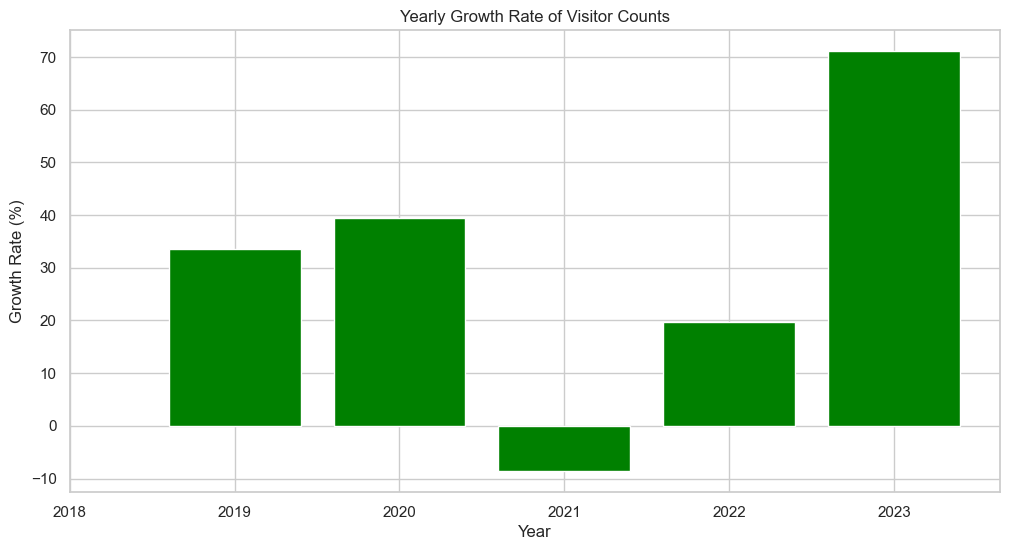

In [188]:
# Calculate the year-over-year percentage change
yearly_data['Total_Visitors'] = yearly_data.sum(axis=1)  # Sum across all sensors
yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100

# Display the growth rates
print("Yearly Growth Rates:")
print(yearly_data['Yearly_Growth_Rate'])

# Plot the growth rates
plt.figure(figsize=(12, 6))
plt.bar(yearly_data.index.year, yearly_data['Yearly_Growth_Rate'], color='green')
plt.title('Yearly Growth Rate of Visitor Counts')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.xticks(yearly_data.index.year)  # Ensure all years are shown on x-axis
plt.show()


In [189]:
import numpy as np

# Get all sensor columns
sensor_columns = final_visitor_counts.columns

# Split the sensors into groups of 10
sensor_groups = np.array_split(sensor_columns, np.ceil(len(sensor_columns) / 10))

# Display how sensors are divided (optional)
for i, group in enumerate(sensor_groups):
    print(f"Group {i + 1}: {list(group)}\n")


Group 1: ['Bayerisch Eisenstein IN', 'Brechhäuslau IN', 'Bucina IN', 'Deffernik IN', 'Felswandergebiet IN', 'Ferdinandsthal IN', 'Gsenget IN', 'Gsenget IN.1']

Group 2: ['Klingenbrunner Wald IN', 'Klosterfilz IN', 'NPZ_Falkenstein IN', 'Racheldiensthütte IN', 'Scheuereck IN', 'Schillerstraße IN', 'TFG_Lusen IN', 'TFG_Lusen_3 TFG Lusen 3 IN']

Group 3: ['Trinkwassertalsperre IN', 'Trinkwassertalsperre_MULTI IN', 'Waldhausreibe IN', 'Waldhausreibe Channel 1 IN', 'Waldspielgelände_1 IN', 'Diensthüttenstraße Fußgänger IN', 'Gfäll Fußgänger IN', 'Sagwassersäge Fußgänger IN']

Group 4: ['Schwarzbachbrücke Fußgänger IN', 'TFG_Falkenstein_1 Fußgänger zum Parkplatz', 'TFG_Falkenstein_2 Fußgänger In Richtung TFG', 'TFG_Lusen_1 Fußgänger Richtung TFG', 'TFG_Lusen_1 Fußgänger Richtung Parkplatz', 'TFG_Lusen_2 Fußgänger Richtung Vögel am Waldrand', 'TFG_Lusen_2 Fußgänger Richtung Parkplatz']



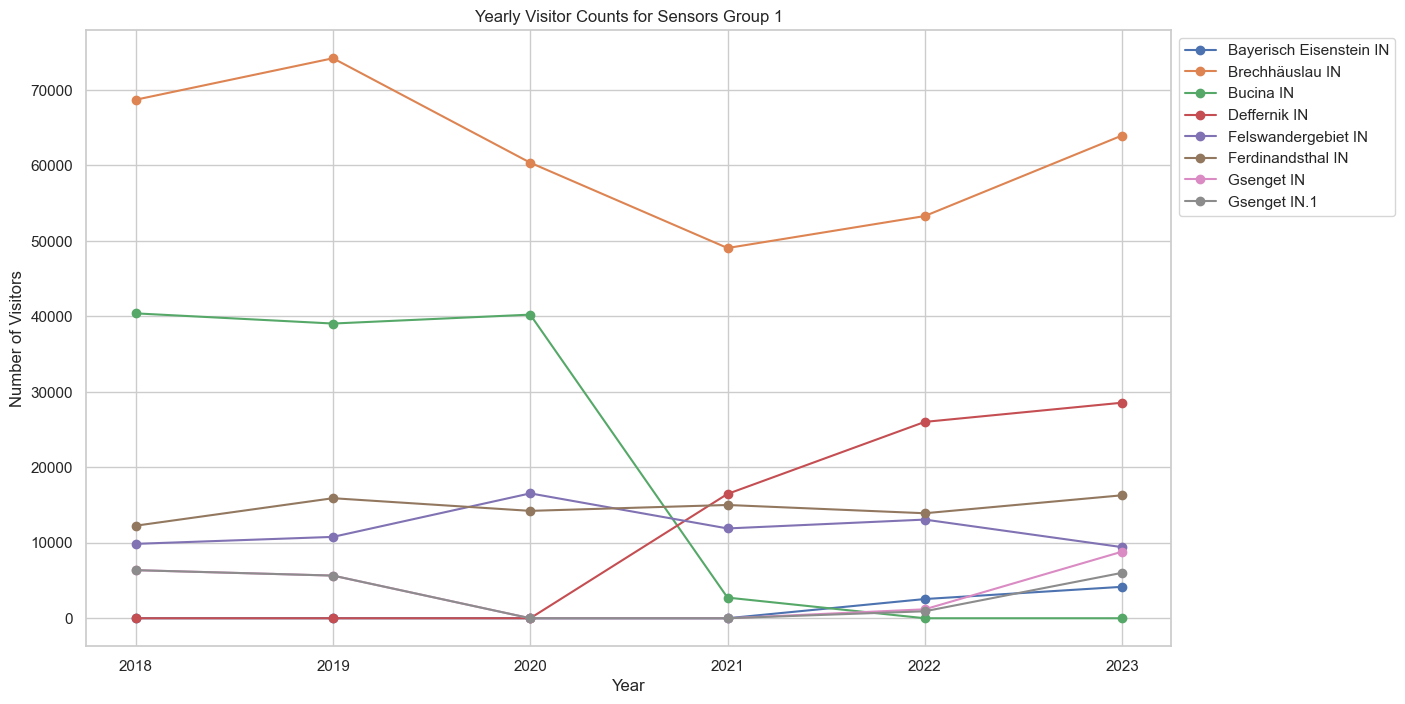

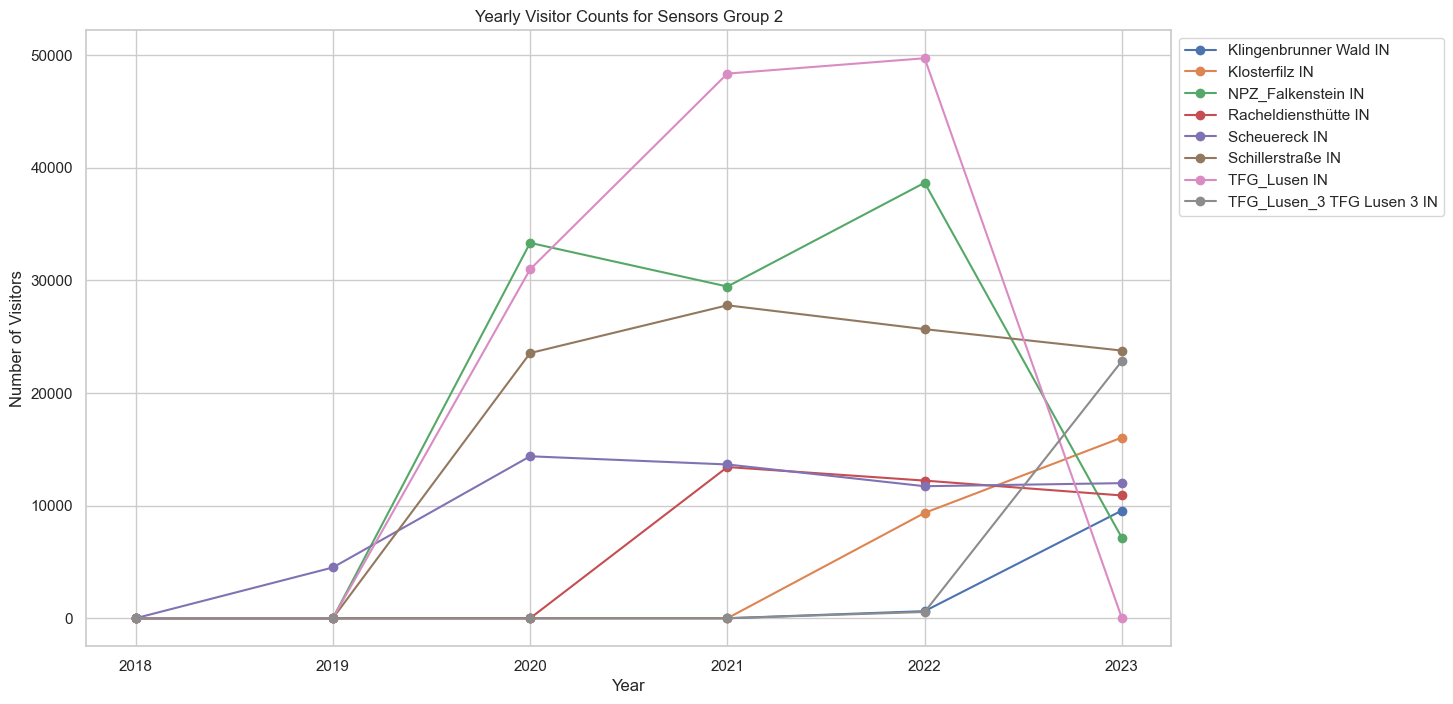

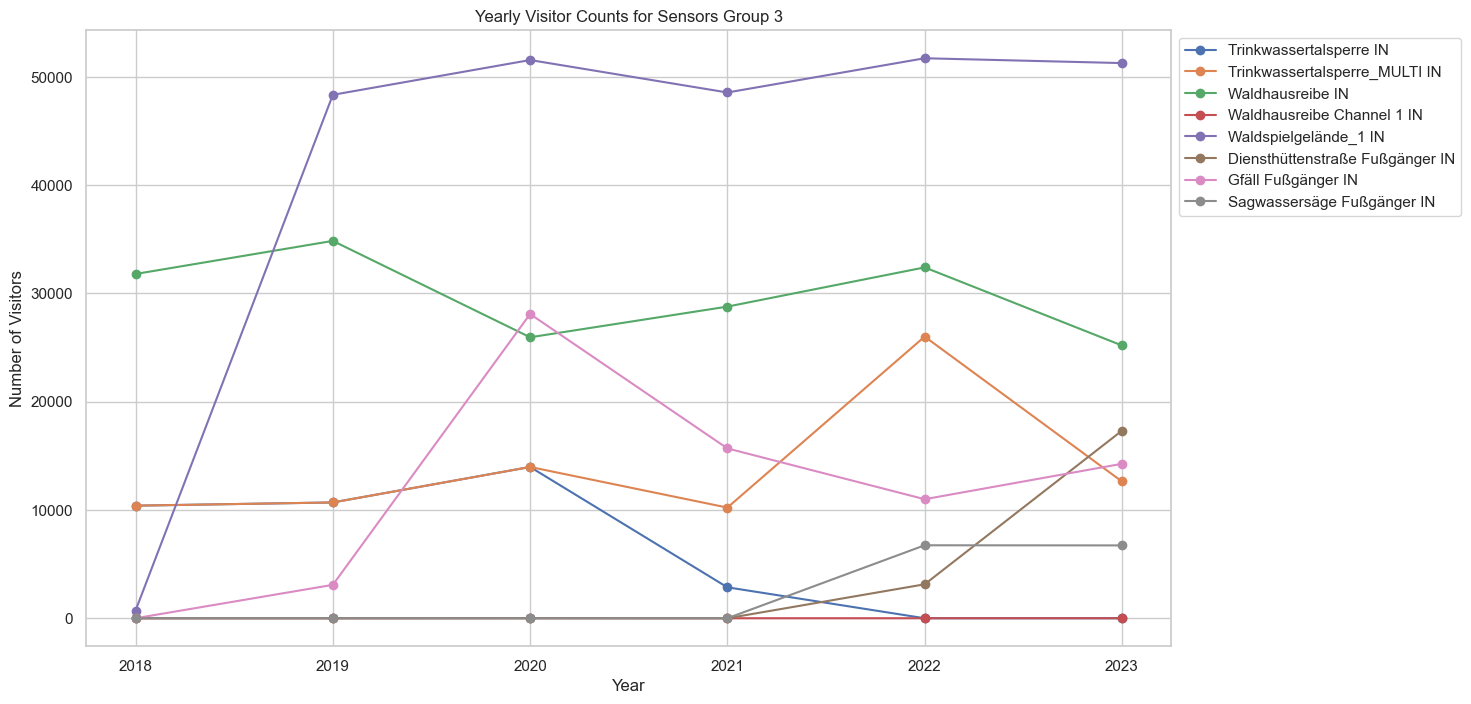

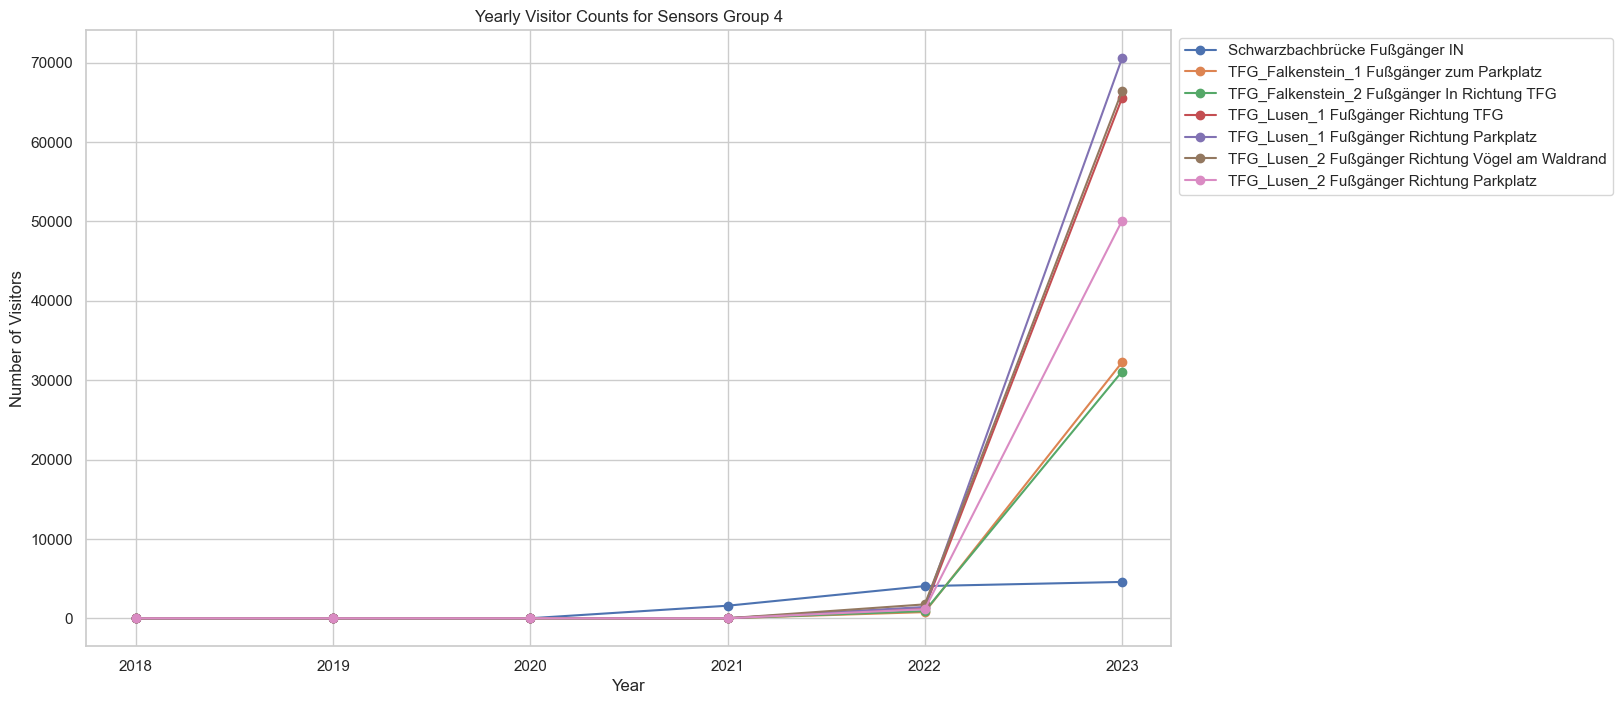

In [190]:
# Loop through each group of sensors and plot their yearly trends
for i, group in enumerate(sensor_groups):
    plt.figure(figsize=(14, 8))
    for sensor in group:
        plt.plot(yearly_data.index.year, yearly_data[sensor], marker='o', label=sensor)
    
    plt.title(f'Yearly Visitor Counts for Sensors Group {i + 1}')
    plt.xlabel('Year')
    plt.ylabel('Number of Visitors')
    plt.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside the plot
    plt.xticks(yearly_data.index.year)  # Ensure all years are shown on x-axis
    plt.show()


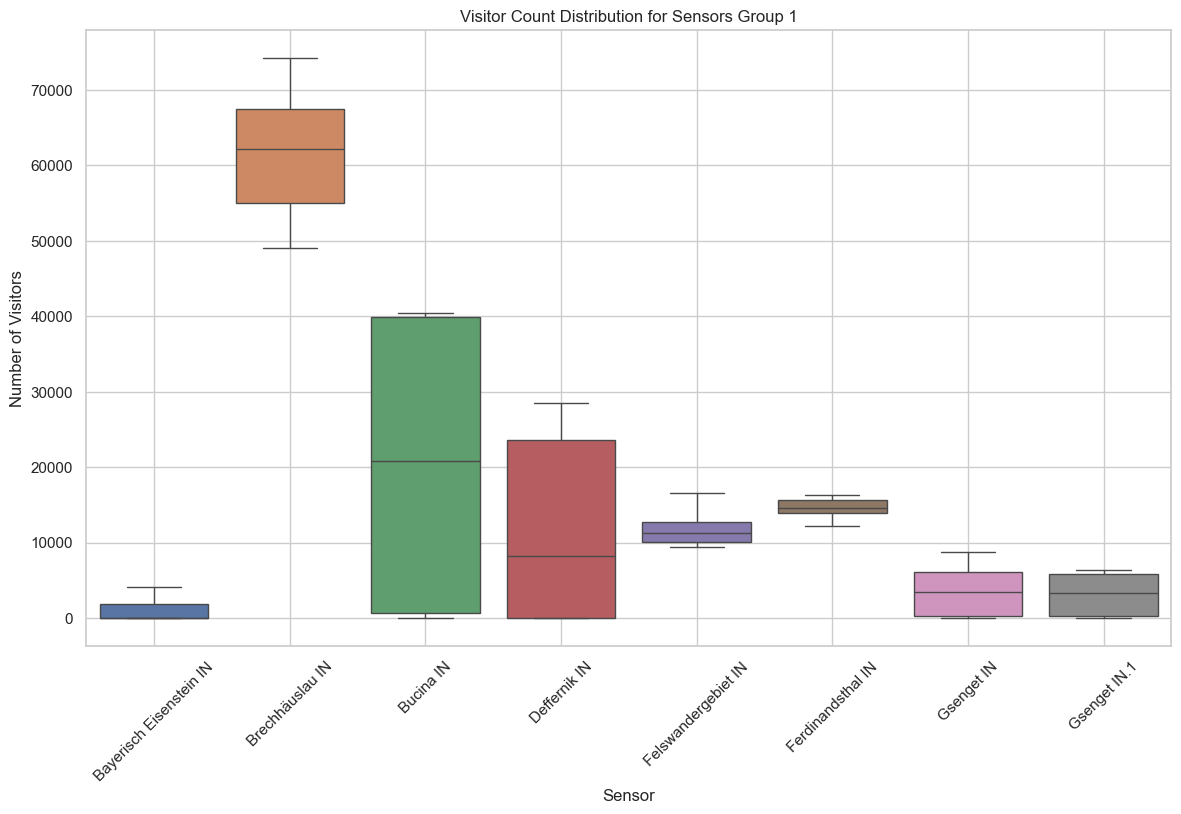

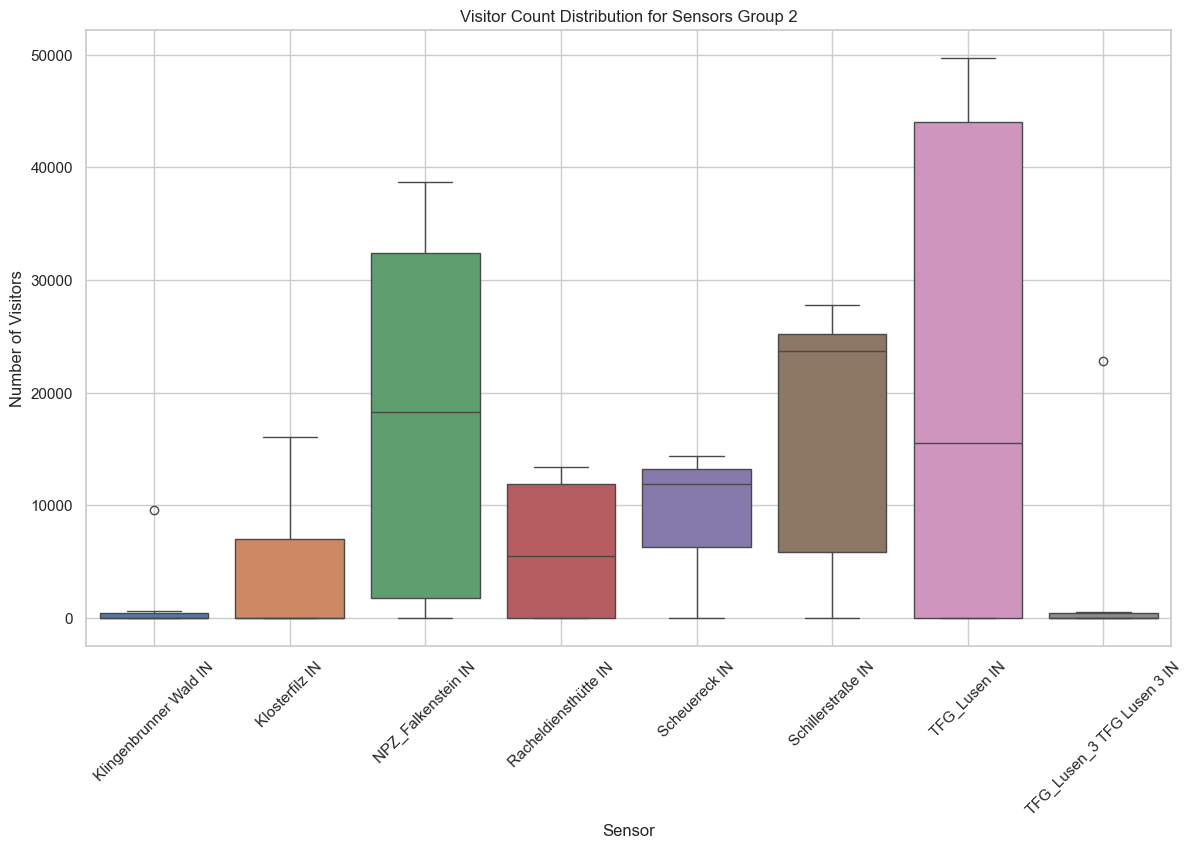

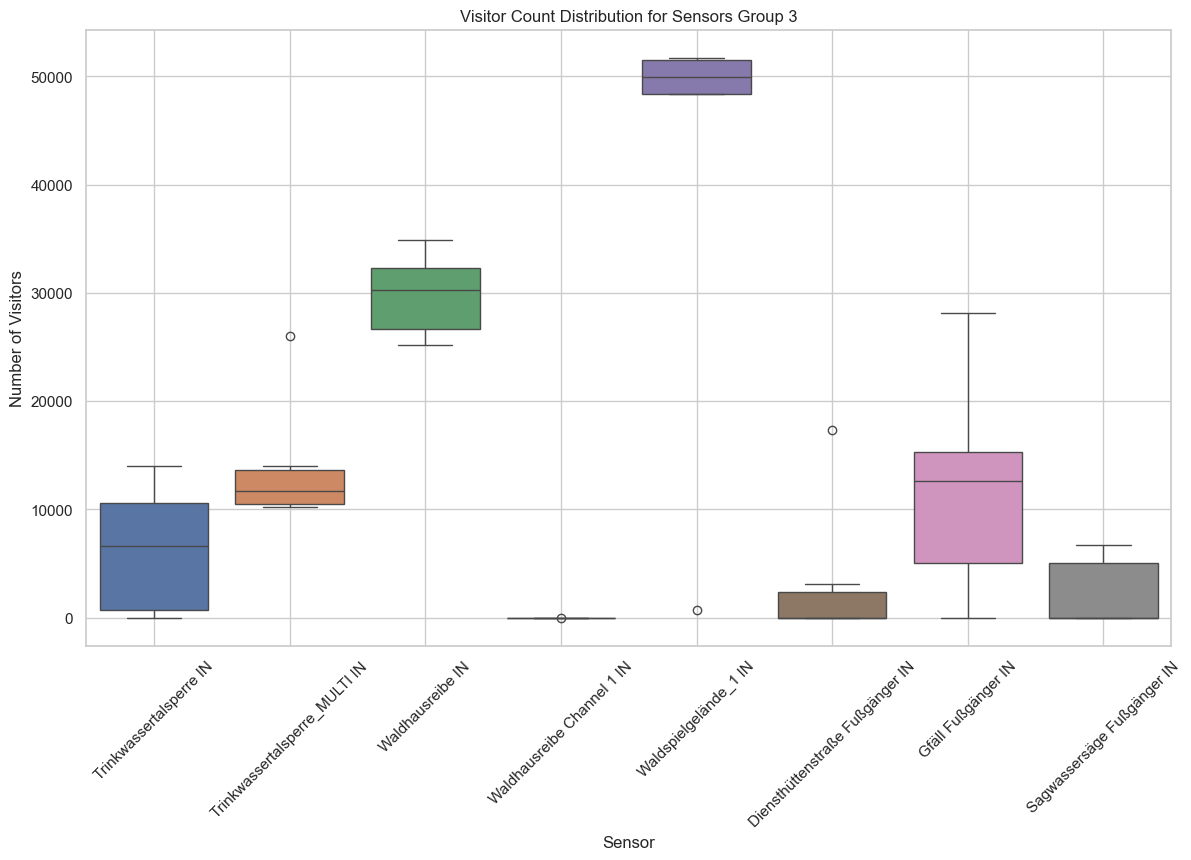

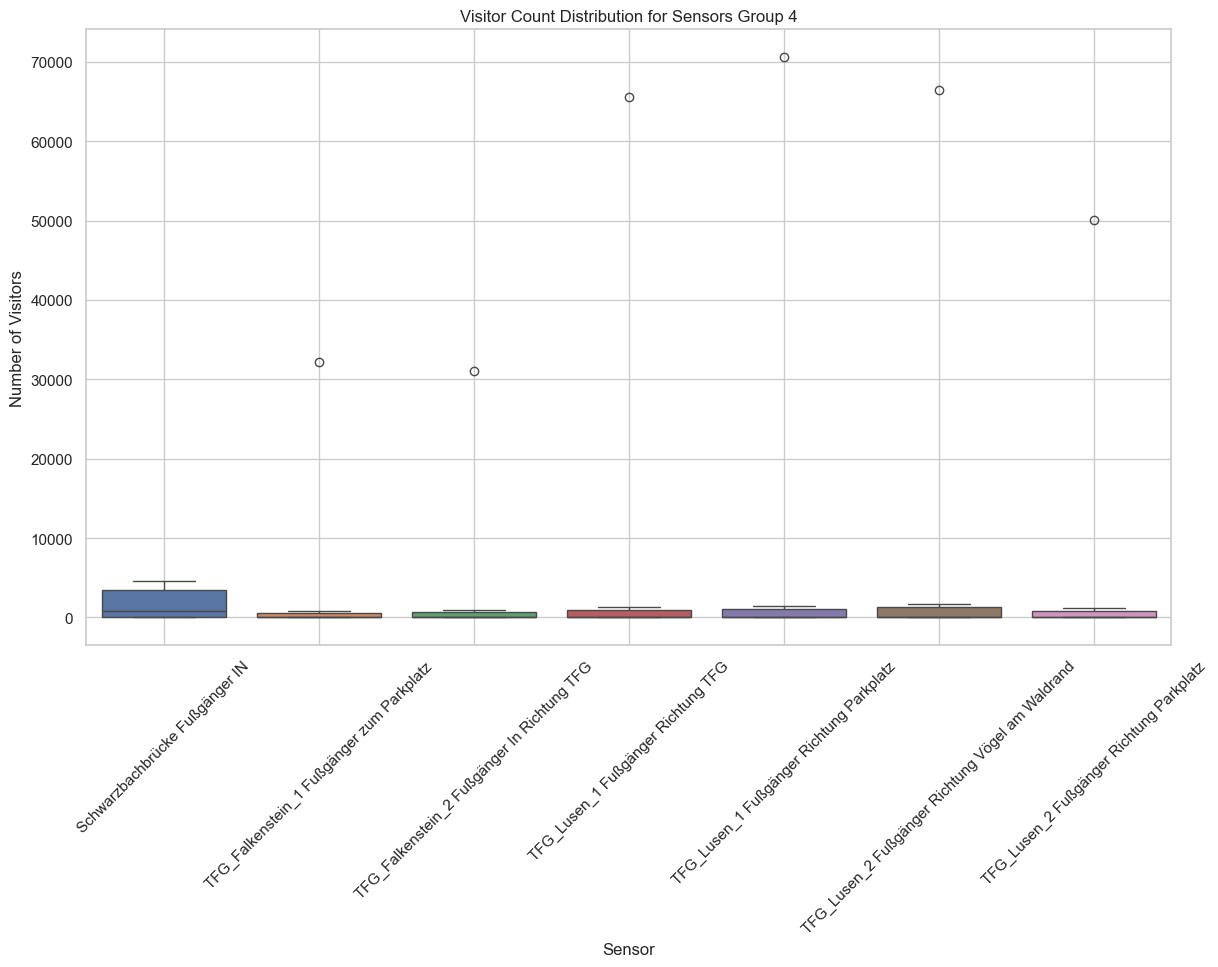

In [191]:
# Box plots to show the distribution of visitor counts across years
for i, group in enumerate(sensor_groups):
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=yearly_data[group])
    plt.title(f'Visitor Count Distribution for Sensors Group {i + 1}')
    plt.xlabel('Sensor')
    plt.ylabel('Number of Visitors')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


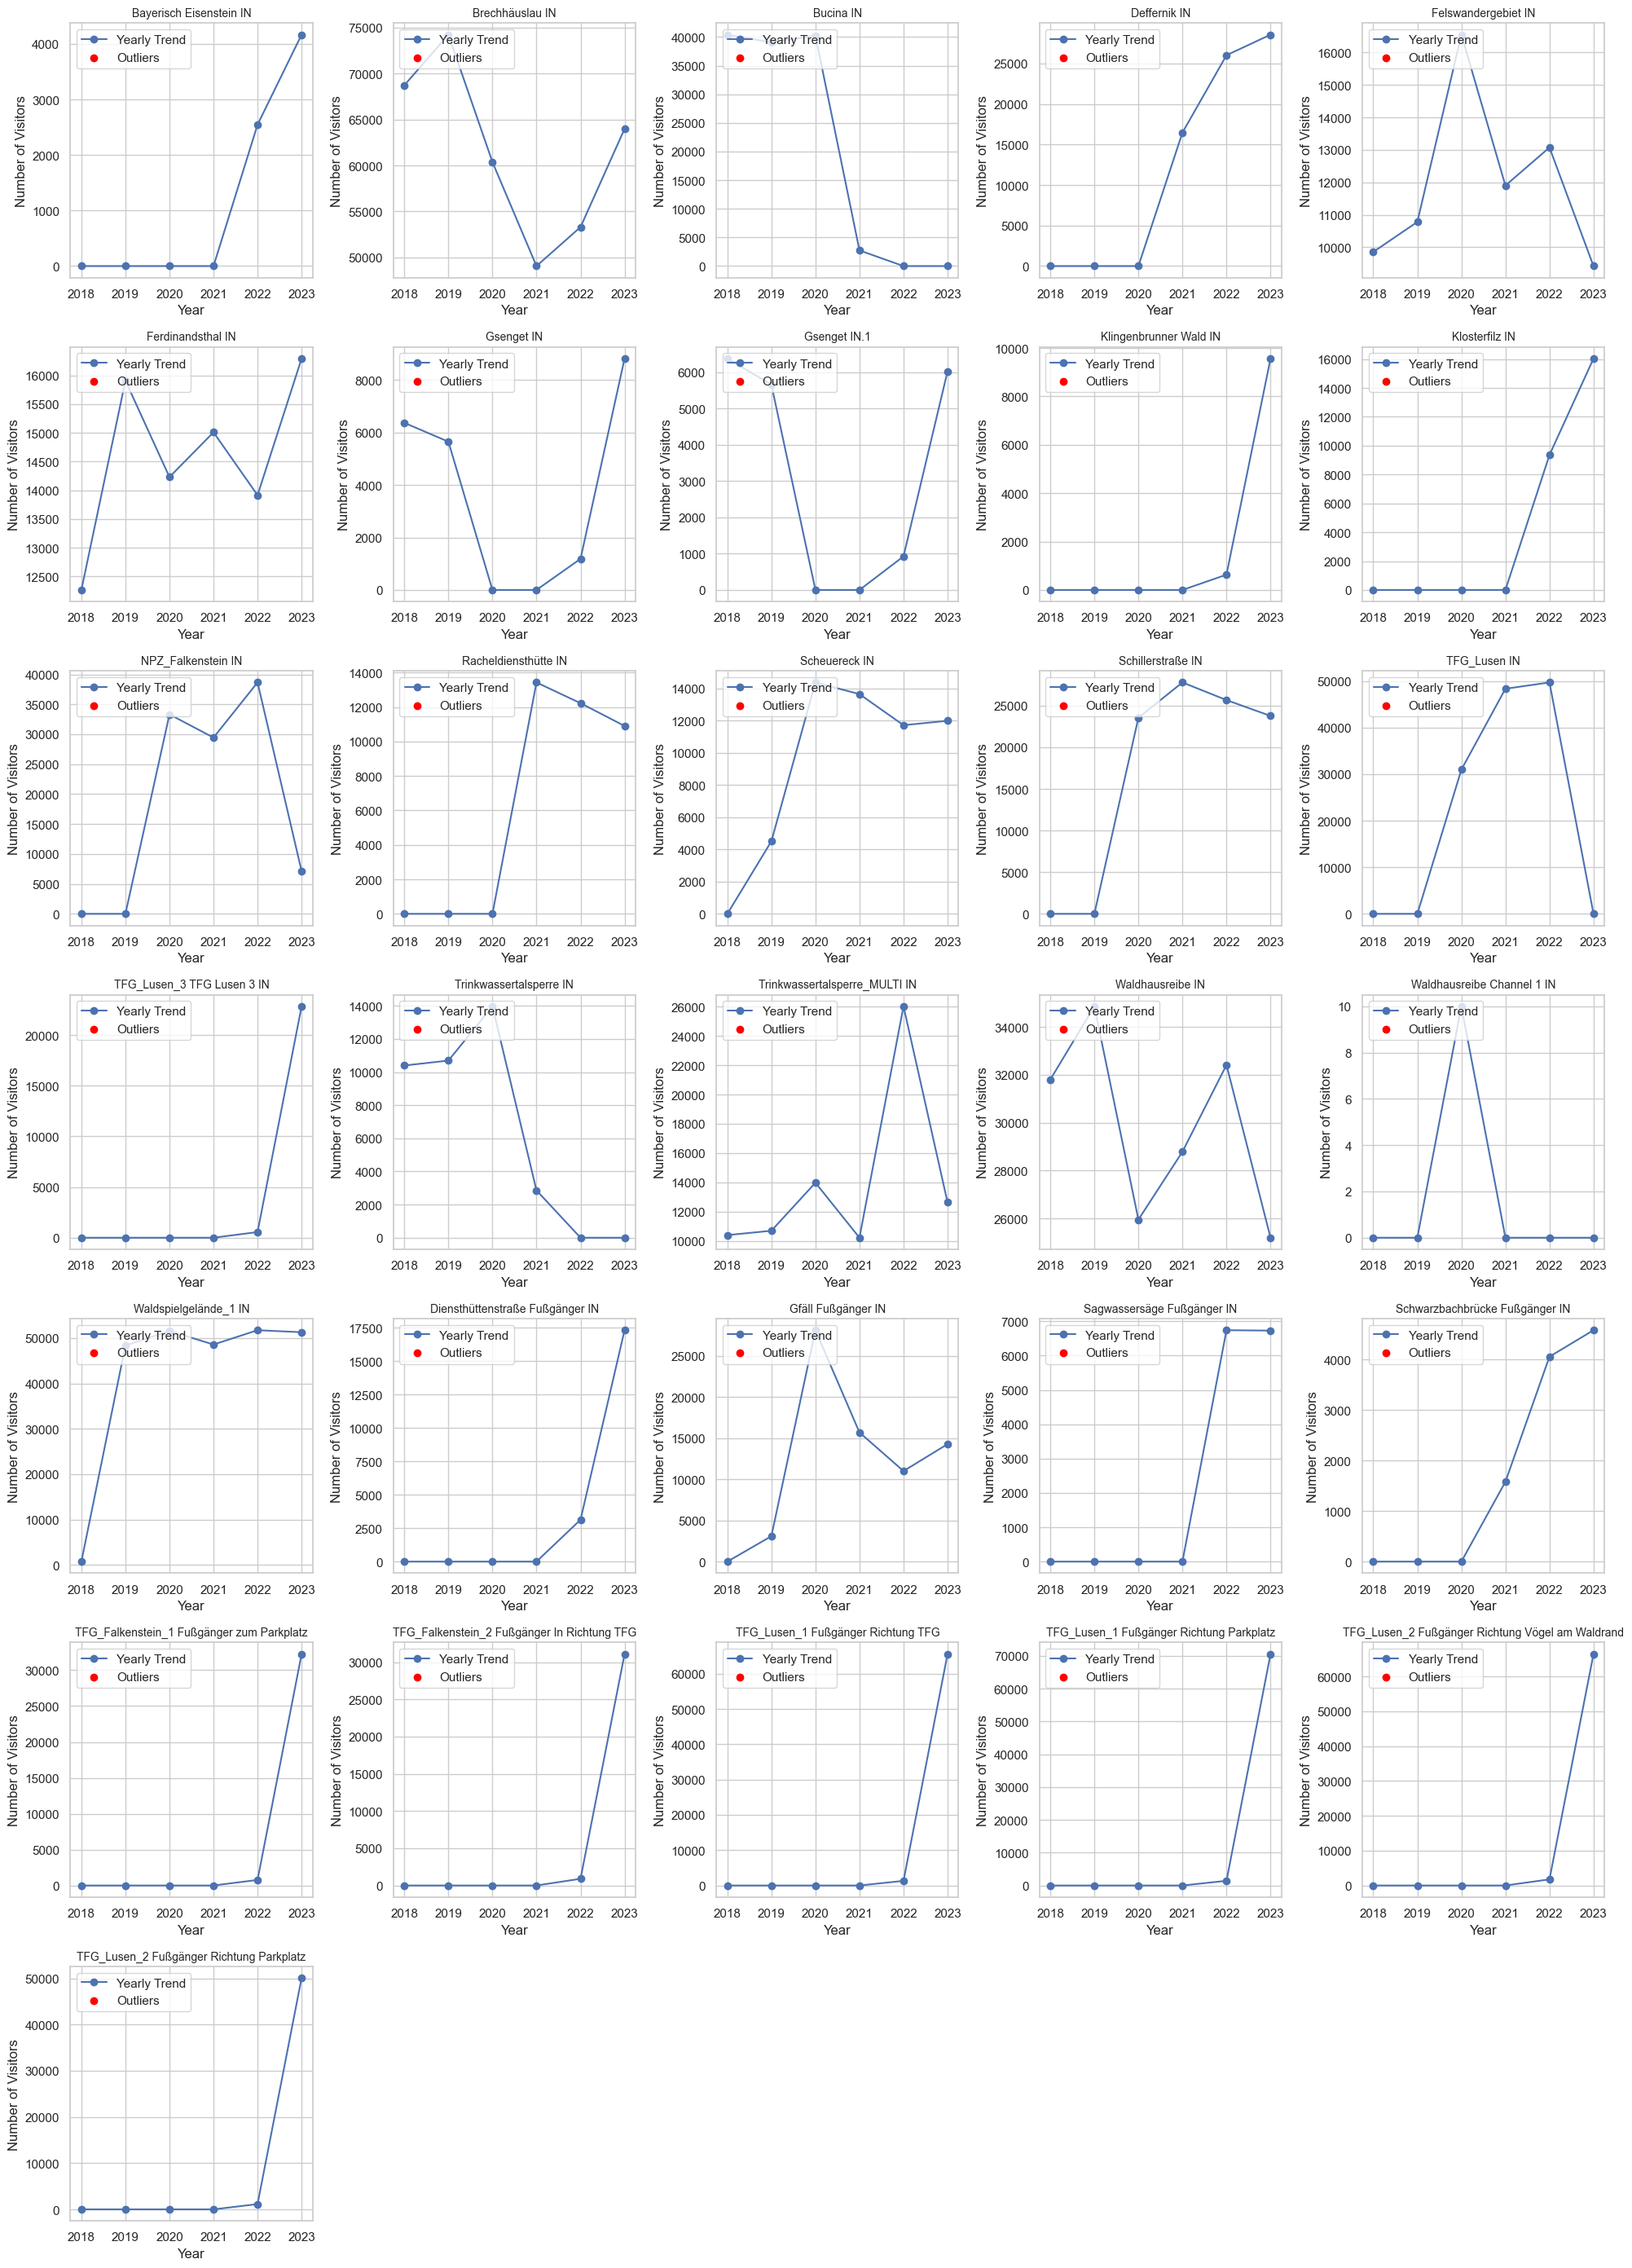

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Define a function to identify outliers using Z-score
def detect_outliers_zscore(data, threshold=3):
    from scipy import stats
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

# Number of sensors per row
sensors_per_row = 5

# Calculate the number of rows needed
num_sensors = len(final_visitor_counts.columns)
num_rows = np.ceil(num_sensors / sensors_per_row).astype(int)

# Create subplots
fig, axes = plt.subplots(num_rows, sensors_per_row, figsize=(20, 4 * num_rows), squeeze=False)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Loop through each sensor and create a subplot
for idx, sensor in enumerate(final_visitor_counts.columns):
    ax = axes[idx]
    
    # Plot the yearly trend
    ax.plot(yearly_data.index.year, yearly_data[sensor], marker='o', label='Yearly Trend')
    
    # Detect outliers
    outliers = detect_outliers_zscore(yearly_data[sensor])
    
    # Plot outliers
    ax.scatter(yearly_data.index.year[outliers], yearly_data[sensor][outliers], color='red', label='Outliers', zorder=5)
    
    # Plot settings
    ax.set_title(sensor, fontsize=10)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Visitors')
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xticks(yearly_data.index.year)
    
    

# Hide any unused subplots
for idx in range(num_sensors, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


###  Monthly Trend Analysis
- Resampling data by month.
- Visualizing monthly trends with detailed plots.

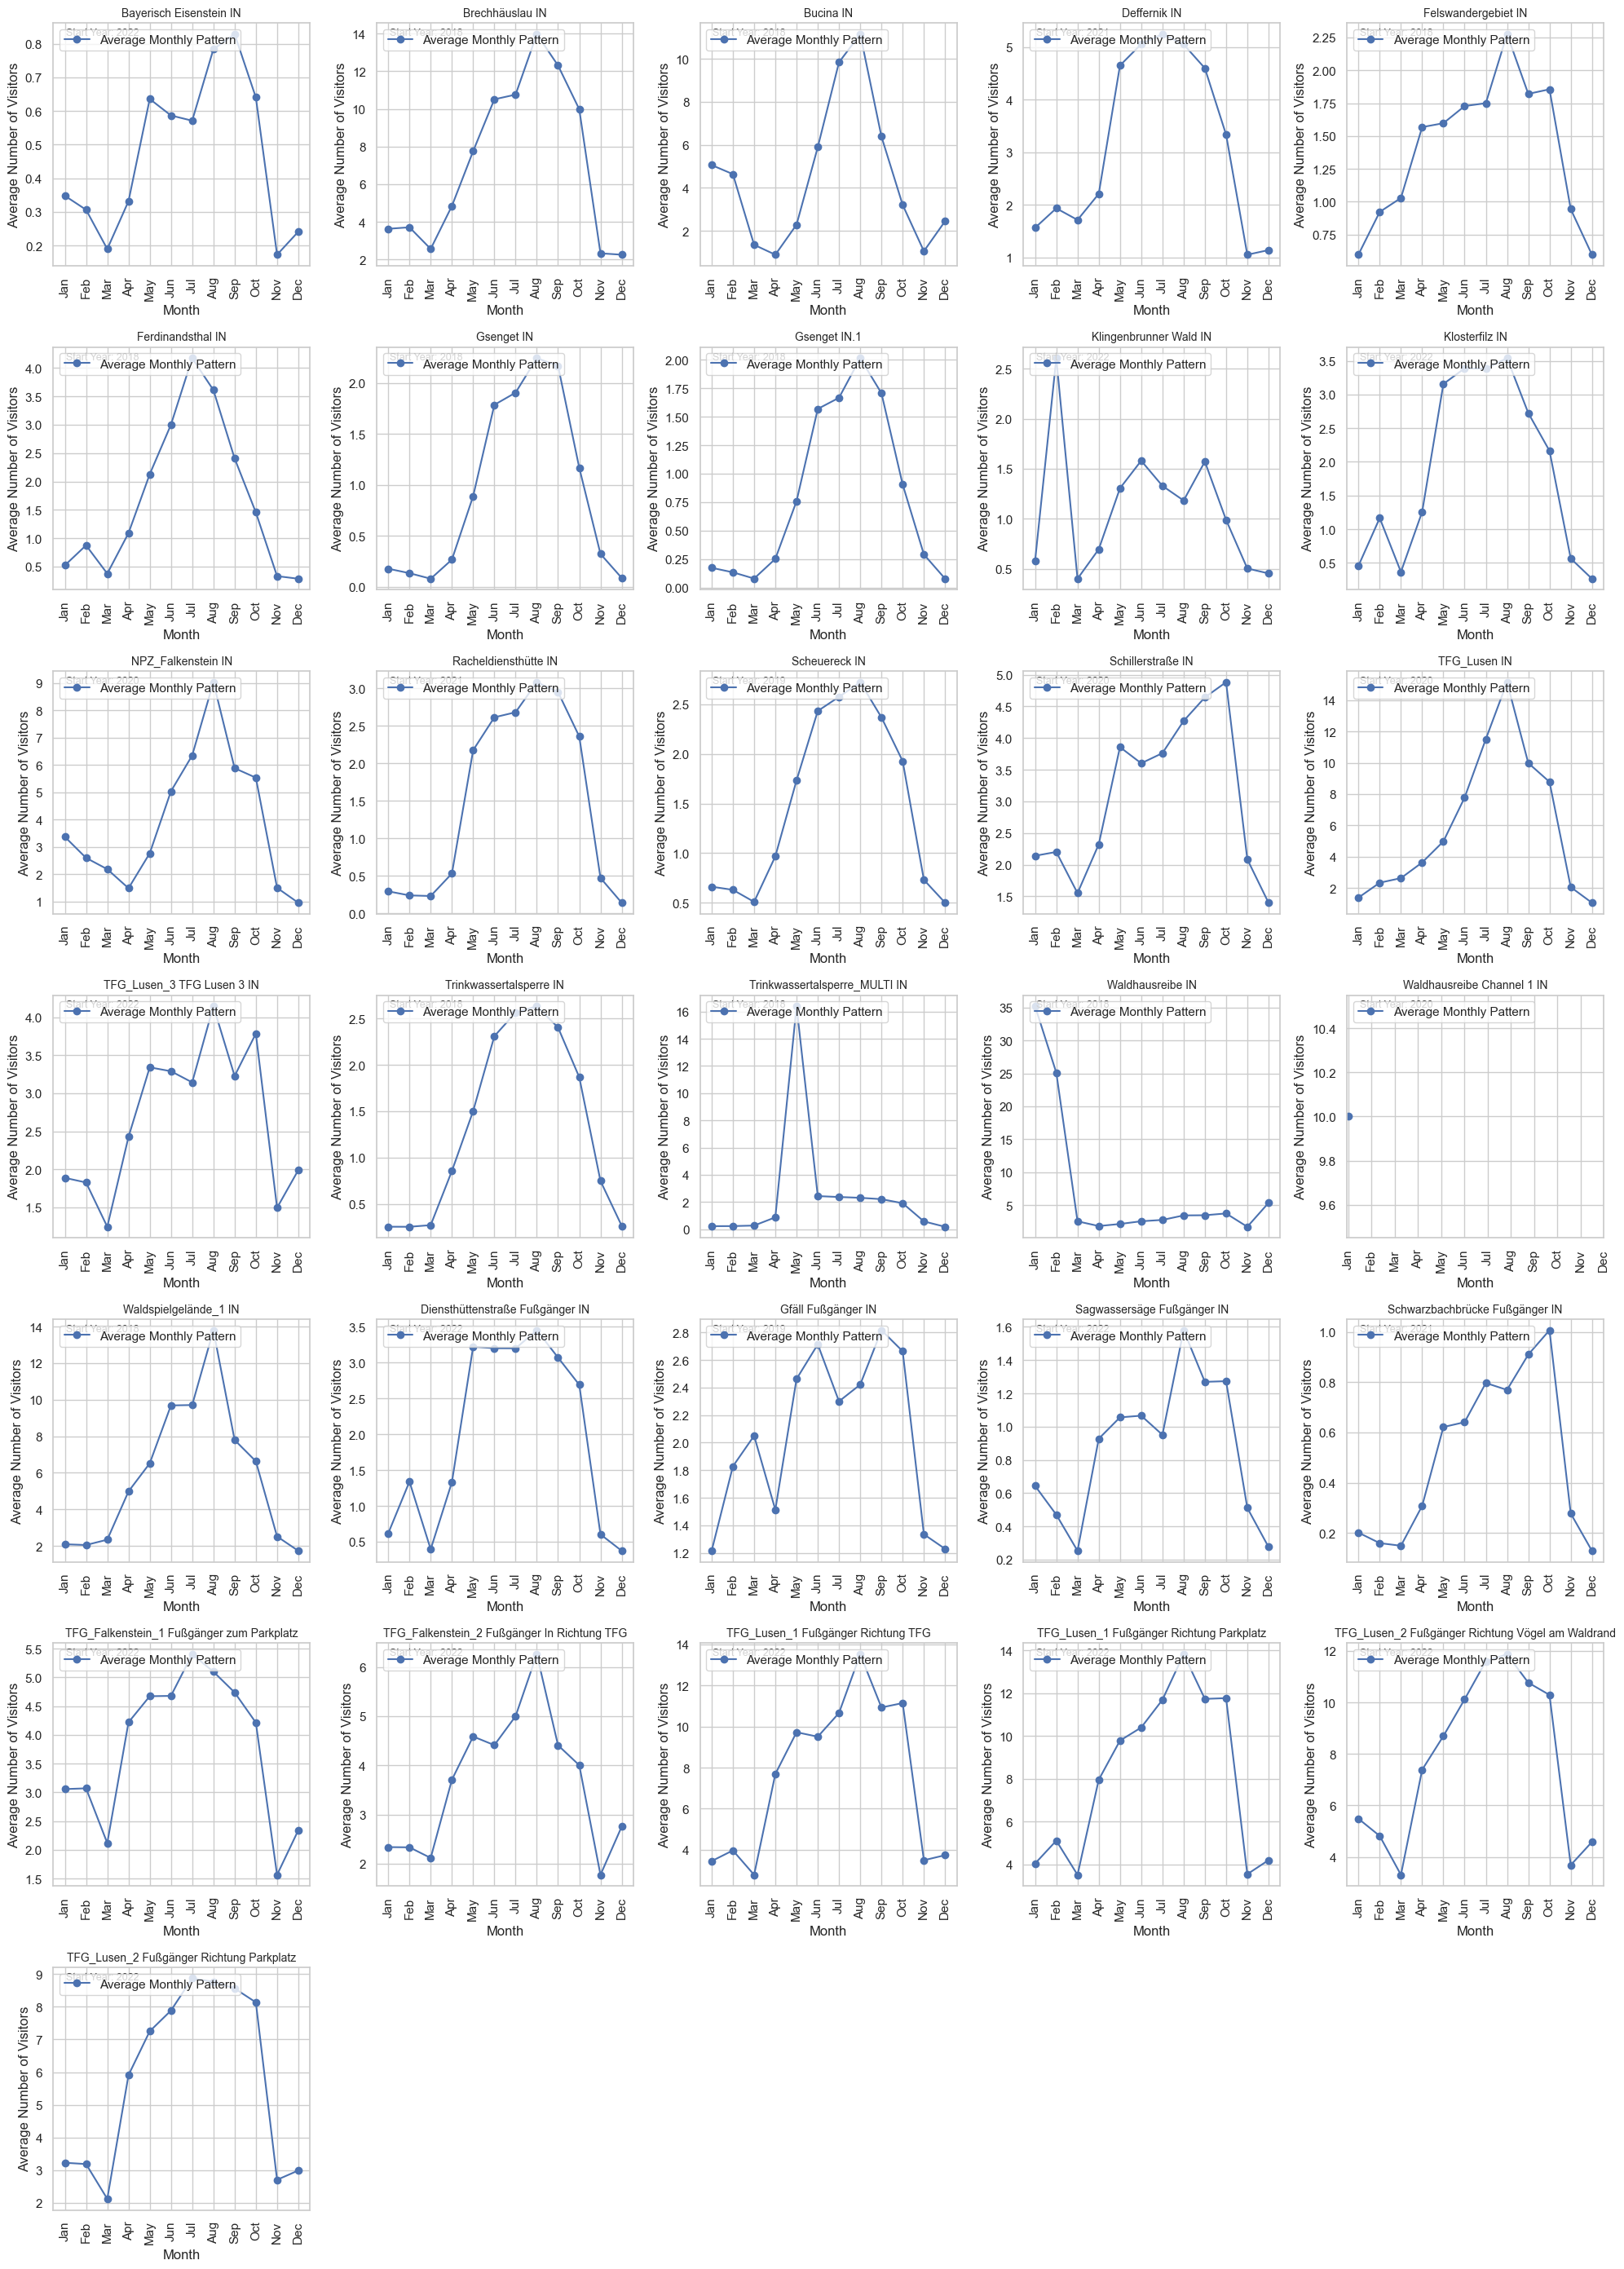

In [193]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set(style="whitegrid")

# Function to calculate average monthly visitor counts
def calculate_monthly_averages(df):
    # Resample data to monthly frequency and compute average
    monthly_data = df.resample('ME').mean()
    # Group by month to get the average across all years
    monthly_averages = monthly_data.groupby(monthly_data.index.month).mean()
    return monthly_averages

# Function to get start years for all sensors in the DataFrame
def get_start_years(df):
    """
    Get the start year for each sensor in the dataframe by finding the first non-NaN entry.
    Returns a dictionary mapping each sensor to its start year.
    """
    start_years = {}
    
    for sensor in df.columns:
        # Drop NaN values and get the first valid entry for each sensor
        first_valid_index = df[sensor].dropna().index[0]
        start_years[sensor] = first_valid_index.year
    
    return start_years

# Assuming 'final_visitor_counts' is your main dataframe with all sensor data
# Compute monthly averages for each sensor
monthly_averages = {}
for sensor in final_visitor_counts.columns:
    monthly_averages[sensor] = calculate_monthly_averages(final_visitor_counts[sensor])

# Get start years for all sensors
start_years = get_start_years(final_visitor_counts)

# Create a grid layout for plotting
sensors_per_row = 5
num_sensors = len(final_visitor_counts.columns)
num_rows = np.ceil(num_sensors / sensors_per_row).astype(int)

fig, axes = plt.subplots(num_rows, sensors_per_row, figsize=(20, 4 * num_rows), squeeze=False)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Define month names for x-axis labels
month_names = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

# Plot average monthly patterns for each sensor
for idx, sensor in enumerate(final_visitor_counts.columns):
    ax = axes[idx]
    
    # Get average monthly data
    monthly_data = monthly_averages[sensor]
    
    # Plot average monthly patterns
    ax.plot(month_names, monthly_data, marker='o', label='Average Monthly Pattern')
    
    # Plot settings
    ax.set_title(sensor, fontsize=10)
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Number of Visitors')
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xticks(month_names)  # Ensure all months are shown on x-axis
    ax.set_xticklabels(month_names, rotation=90)  # Rotate month names vertically
    
    # Display the start year for visitor counting
    start_year = start_years[sensor]  # Get start year from the dictionary
    ax.text(0.05, 0.95, f'Start Year: {start_year}', fontsize=9, ha='left', transform=ax.transAxes)

# Hide any unused subplots
for idx in range(num_sensors, len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout
plt.tight_layout()
plt.show()


## 1. Sensor Data Grouping Based on Variability 

### 1.1. Calculating Sensor Variability

In [194]:
# Calculate standard deviation for each sensor to assess variability
variability = final_visitor_counts.groupby(final_visitor_counts.index.year).std().mean()
# Sort sensors by variability
sorted_sensors = variability.sort_values(ascending=False)


### 1.2. Grouping Sensors by variability

In [195]:
# Define thresholds based on quantiles
quantiles = sorted_sensors.quantile([0, 0.33, 0.67, 1.0])
high_variation = sorted_sensors[sorted_sensors >= quantiles[0.67]]
moderate_variation = sorted_sensors[(sorted_sensors < quantiles[0.67]) & (sorted_sensors >= quantiles[0.33])]
low_variation = sorted_sensors[sorted_sensors < quantiles[0.33]]

# Extract sensor names for each group
high_variation_sensors = high_variation.index
moderate_variation_sensors = moderate_variation.index
low_variation_sensors = low_variation.index


### 1.3. Visualizing Sensor Data by Variability

In [196]:
combined_monthly_averages = monthly_averages

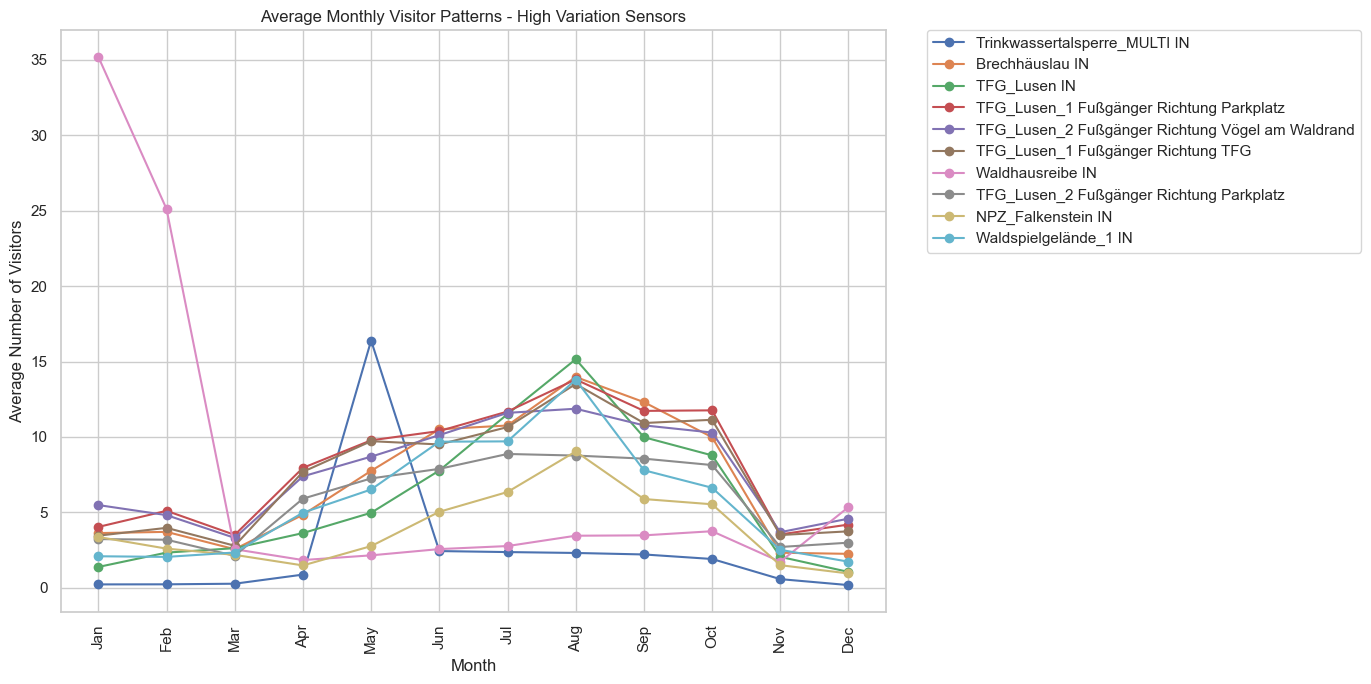

In [197]:
# Plot average monthly patterns for high variation sensors
plt.figure(figsize=(14, 7))
for sensor in high_variation_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - High Variation Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()


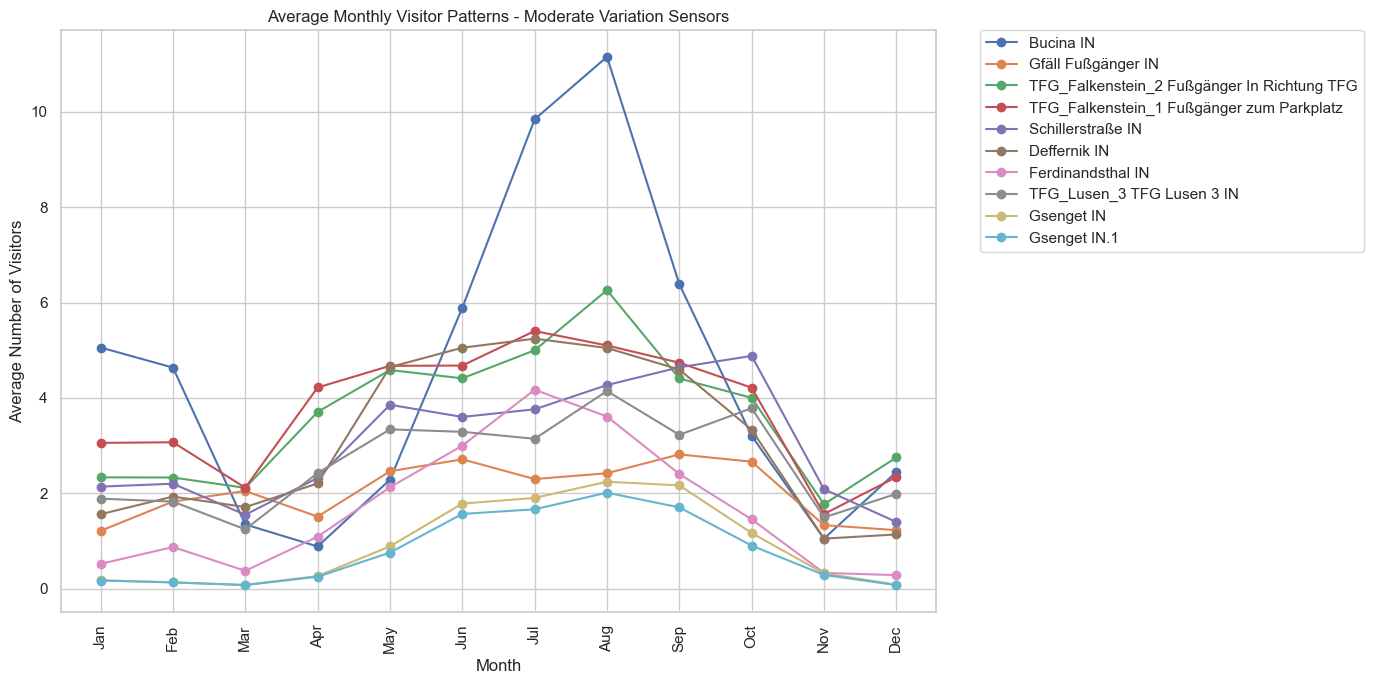

In [198]:
# Plot average monthly patterns for moderate variation sensors
plt.figure(figsize=(14, 7))
for sensor in moderate_variation_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - Moderate Variation Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()


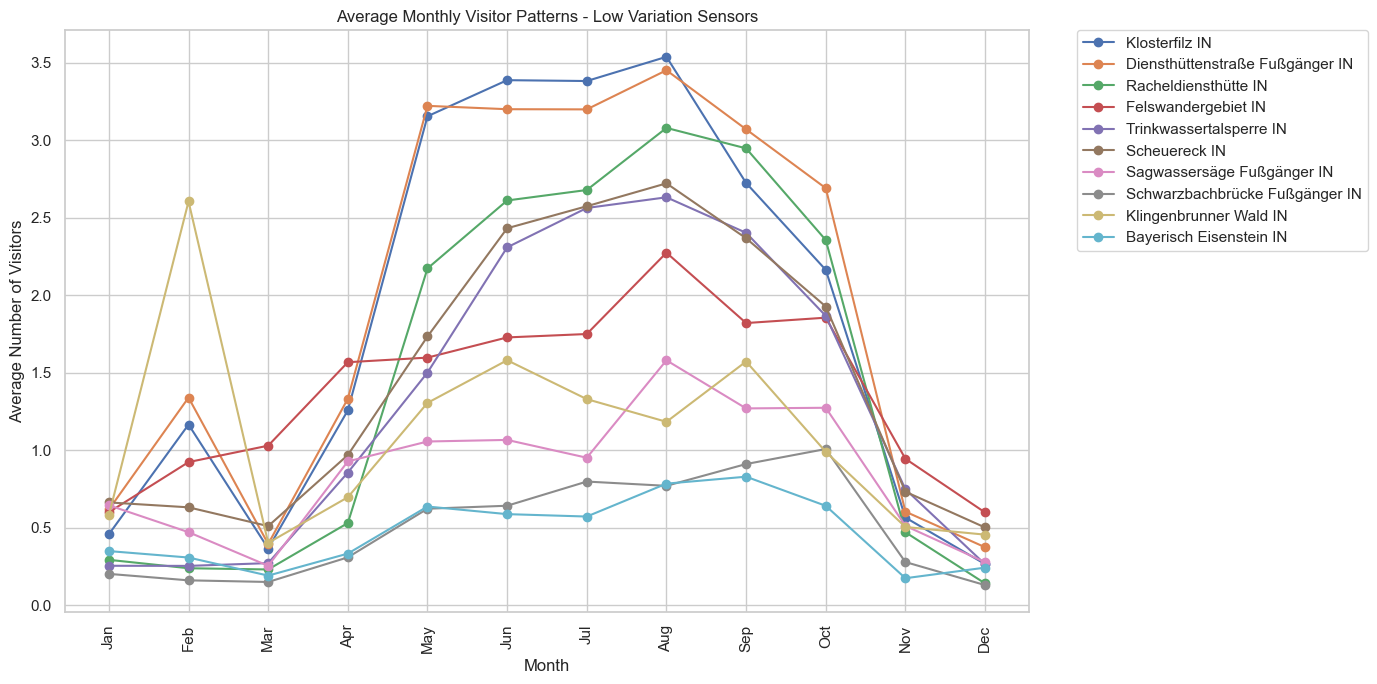

In [199]:
# Plot average monthly patterns for low variation sensors
plt.figure(figsize=(14, 7))
for sensor in low_variation_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - Low Variation Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()


## 2. Visualizing Sensor Data by Traffic Volume

In [200]:
# Calculate total traffic for each sensor
total_traffic = final_visitor_counts.sum()


### 2.2. Define Groups

In [201]:
# Define thresholds based on quantiles
traffic_quantiles = total_traffic.quantile([0, 0.33, 0.67, 1.0])
high_traffic = total_traffic[total_traffic >= traffic_quantiles[0.67]]
moderate_traffic = total_traffic[(total_traffic < traffic_quantiles[0.67]) & (total_traffic >= traffic_quantiles[0.33])]
low_traffic = total_traffic[total_traffic < traffic_quantiles[0.33]]

# Extract sensor names for each group
high_traffic_sensors = high_traffic.index
moderate_traffic_sensors = moderate_traffic.index
low_traffic_sensors = low_traffic.index


### 2.3. plot Groups

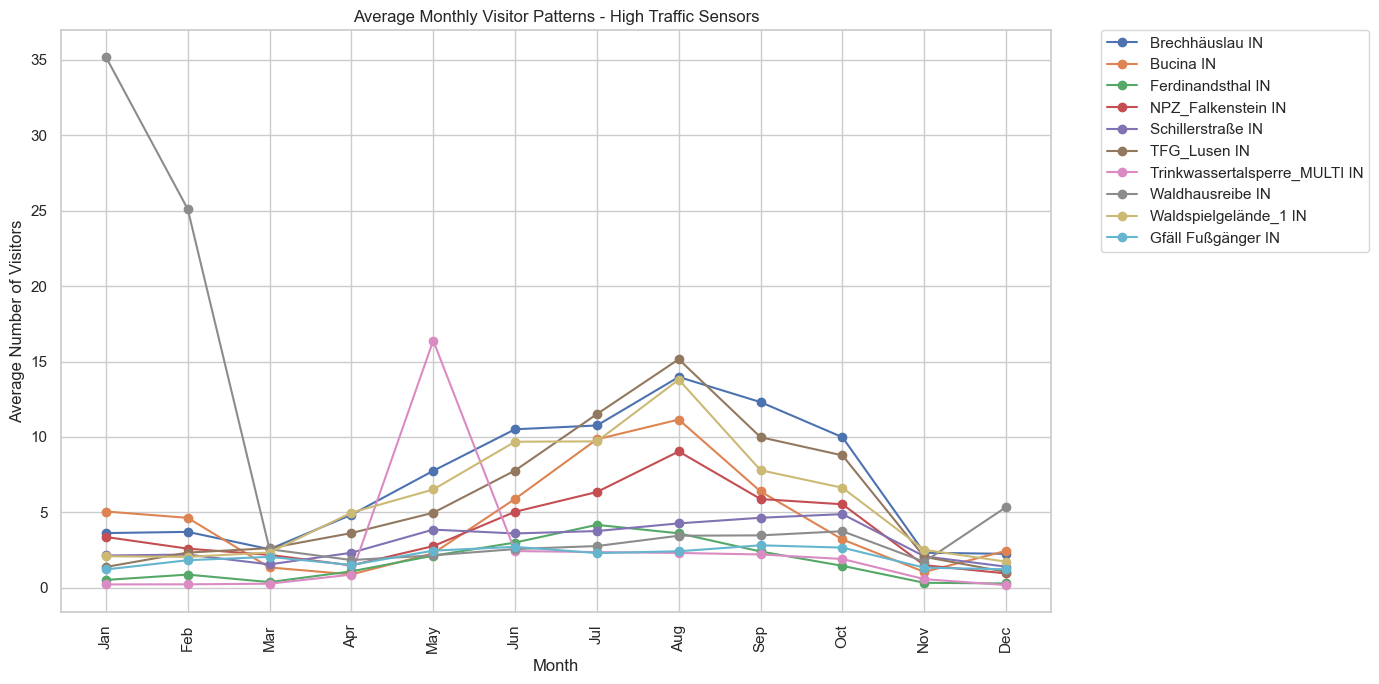

In [202]:
# Plot average monthly patterns for high traffic sensors
plt.figure(figsize=(14, 7))
for sensor in high_traffic_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - High Traffic Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()


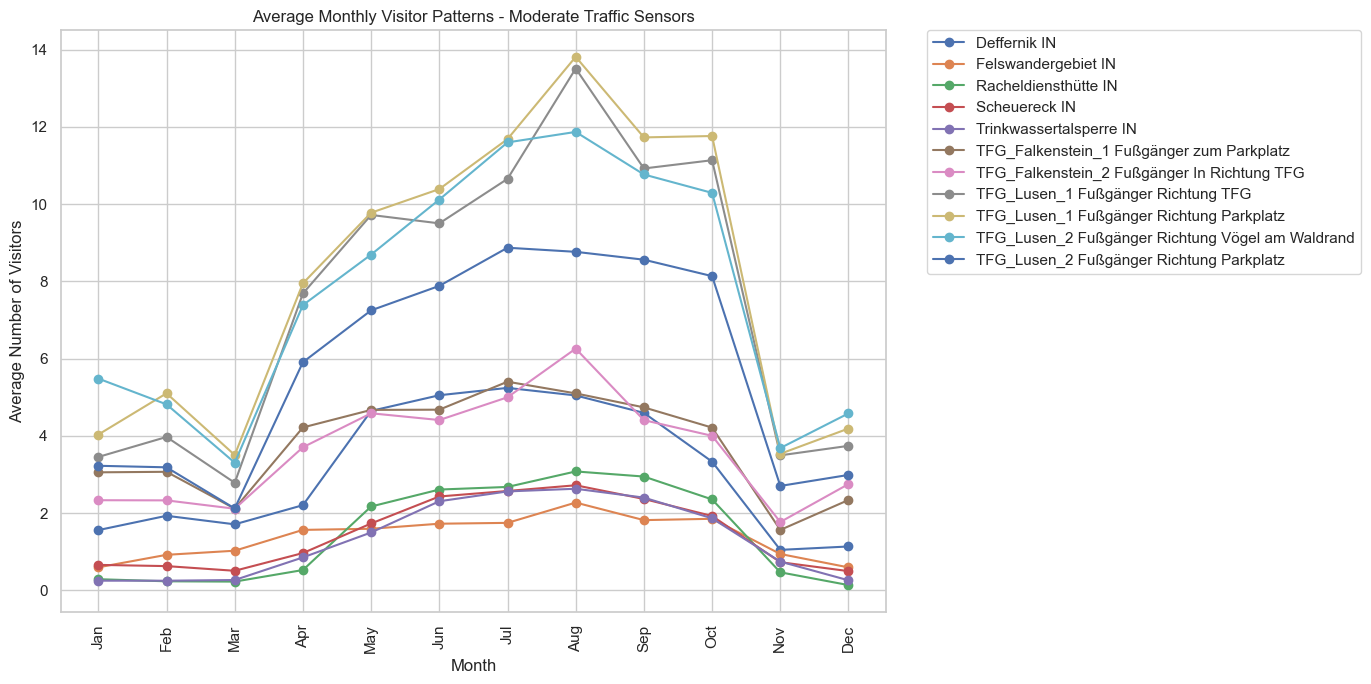

In [203]:
# Plot average monthly patterns for moderate traffic sensors
plt.figure(figsize=(14, 7))
for sensor in moderate_traffic_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - Moderate Traffic Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()
    

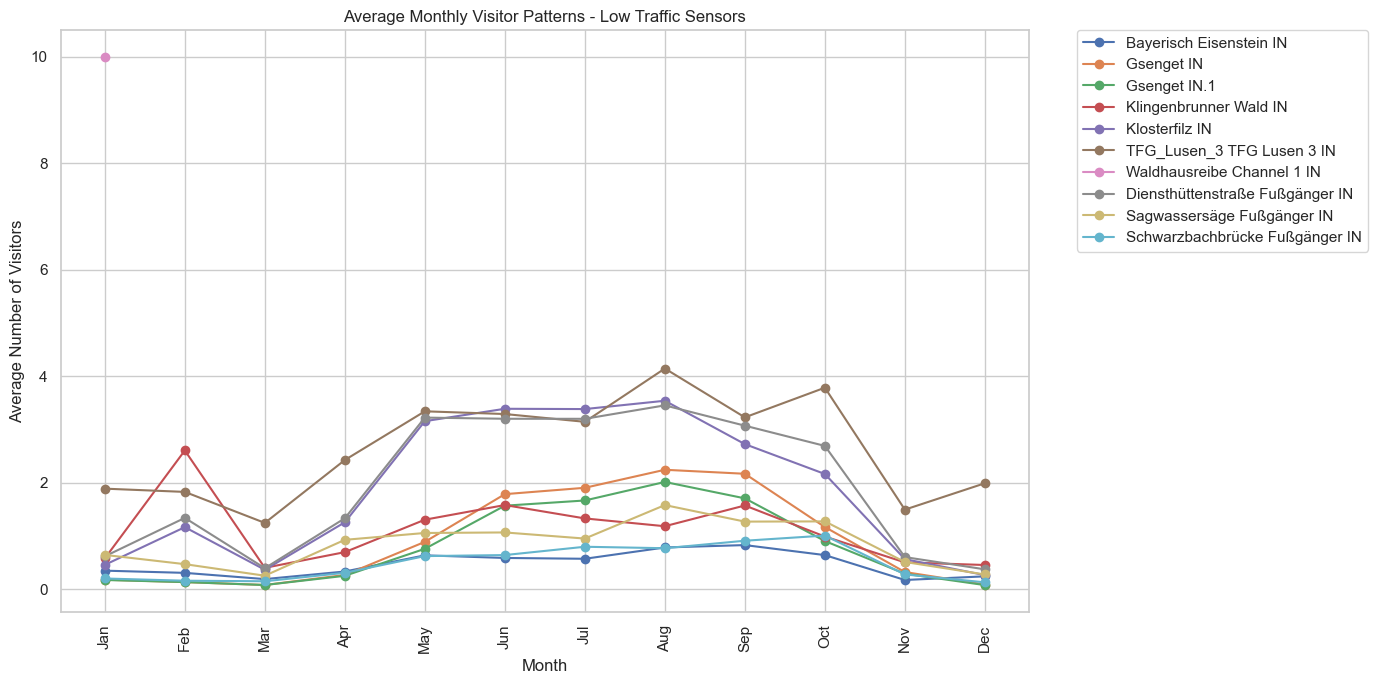

In [204]:
# Plot average monthly patterns for low traffic sensors
plt.figure(figsize=(14, 7))
for sensor in low_traffic_sensors:
    plt.plot(month_names, combined_monthly_averages[sensor], marker='o', label=sensor)

plt.title('Average Monthly Visitor Patterns - Low Traffic Sensors')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.xticks(rotation=90)  # Rotate month names vertically for better readability

plt.tight_layout()
plt.show()


### Seasonal Decomposition
- Decomposing the time series data into trend, seasonal, and residual components.
- Visualizing the decomposition results.

### handle missing values 

In [205]:
# Fill missing values using forward fill and backward fill
final_visitor_counts = final_visitor_counts.fillna(method='ffill').fillna(method='bfill')


C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_19148\1700134472.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_visitor_counts = final_visitor_counts.fillna(method='ffill').fillna(method='bfill')


In [206]:
# Check for any remaining missing values
print(final_visitor_counts.isnull().sum())

Bayerisch Eisenstein IN                             0
Brechhäuslau IN                                     0
Bucina IN                                           0
Deffernik IN                                        0
Felswandergebiet IN                                 0
Ferdinandsthal IN                                   0
Gsenget IN                                          0
Gsenget IN.1                                        0
Klingenbrunner Wald IN                              0
Klosterfilz IN                                      0
NPZ_Falkenstein IN                                  0
Racheldiensthütte IN                                0
Scheuereck IN                                       0
Schillerstraße IN                                   0
TFG_Lusen IN                                        0
TFG_Lusen_3 TFG Lusen 3 IN                          0
Trinkwassertalsperre IN                             0
Trinkwassertalsperre_MULTI IN                       0
Waldhausreibe IN            

### Perform Seasonal Decomposition

Duplicate timestamps:
 DatetimeIndex(['2018-03-25 03:00:00', '2019-03-31 03:00:00',
               '2020-03-29 03:00:00', '2021-03-28 03:00:00',
               '2022-03-27 03:00:00', '2023-03-26 03:00:00',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
               ...
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT',
                               'NaT',                 'NaT'],
              dtype='datetime64[ns]', name='Time', length=8765, freq=None)


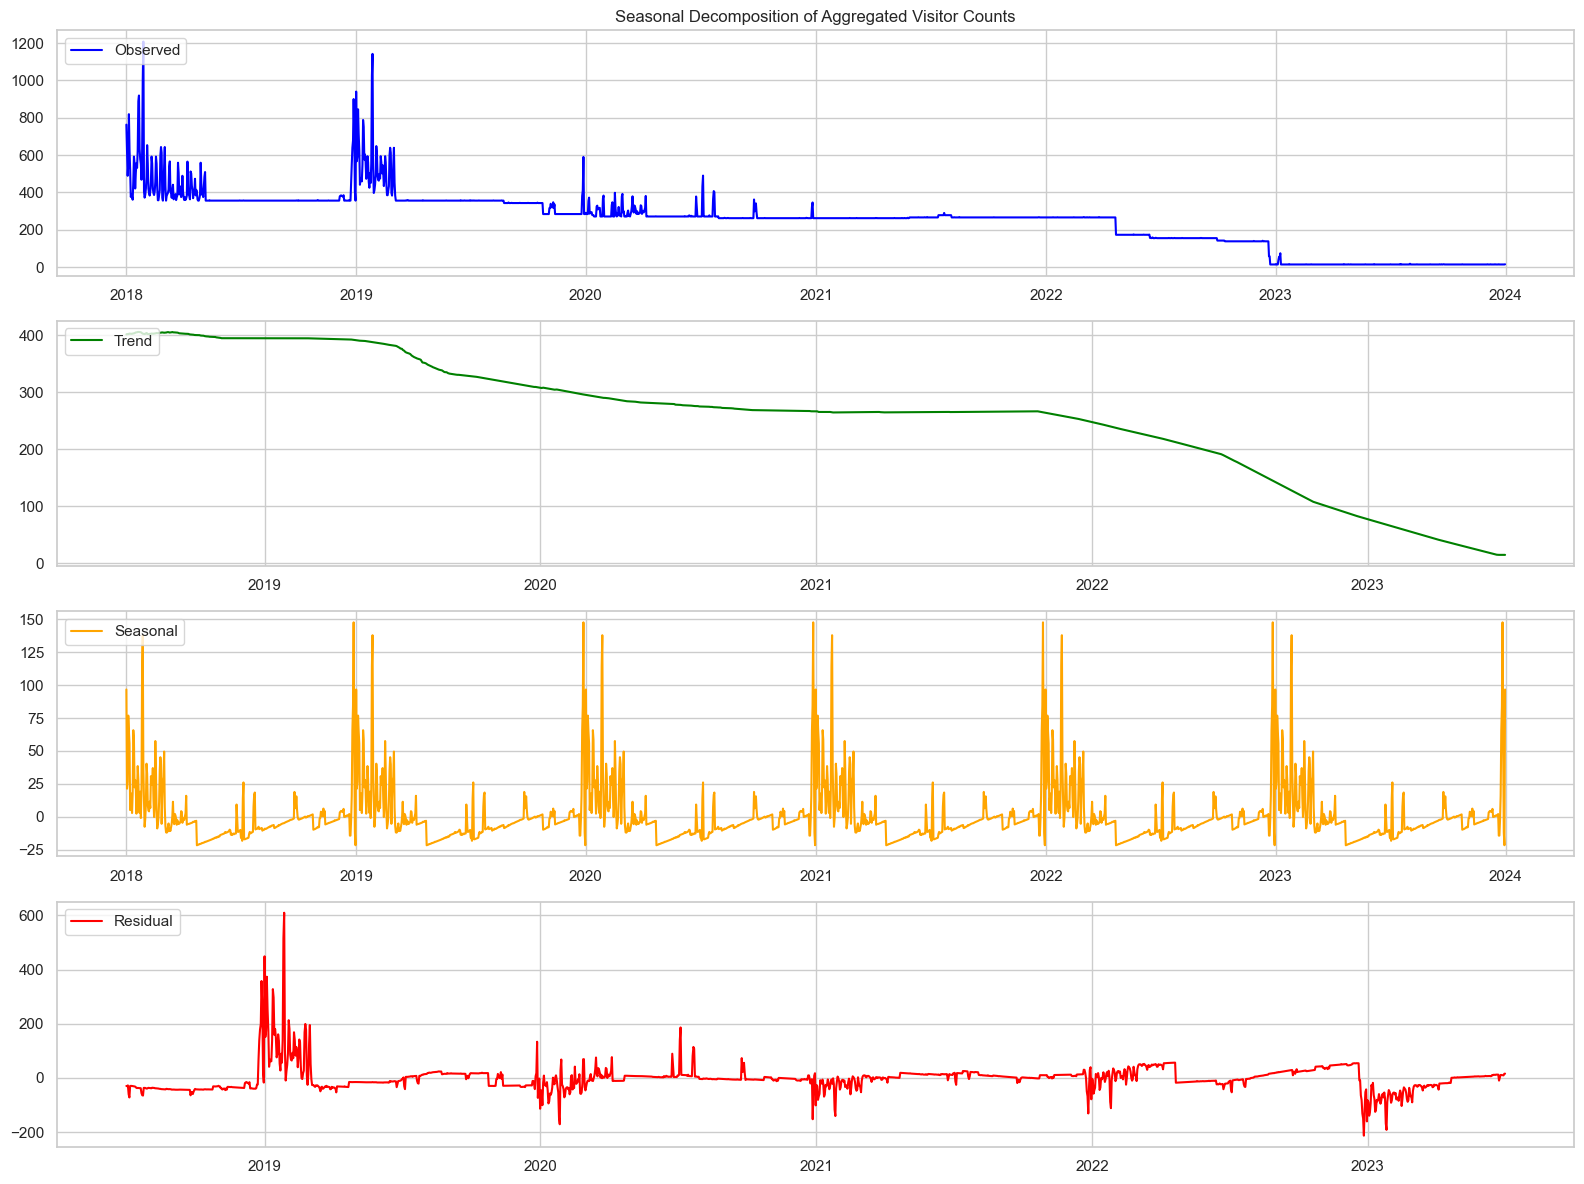

In [207]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Sum the values across all sensors to get an aggregated time series
aggregated_data = final_visitor_counts.sum(axis=1)

# Check and handle duplicates
duplicates = aggregated_data.index[aggregated_data.index.duplicated()]
print("Duplicate timestamps:\n", duplicates)

# Remove duplicates by summing
aggregated_data = aggregated_data.groupby(aggregated_data.index).sum()

# Ensure index is a DatetimeIndex
aggregated_data.index = pd.to_datetime(aggregated_data.index)

# Set the frequency to daily; adjust as necessary
aggregated_data = aggregated_data.asfreq('D')

# Specify period based on your data
period = 365  # Adjust based on expected seasonality

# Perform seasonal decomposition
decomposition = seasonal_decompose(aggregated_data, model='additive', period=period)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
observed = decomposition.observed

# Plot the decomposition
plt.figure(figsize=(16, 12))

# Plot observed data
plt.subplot(4, 1, 1)
plt.plot(observed, label='Observed', color='blue')
plt.title('Seasonal Decomposition of Aggregated Visitor Counts')
plt.legend(loc='upper left')

# Plot trend component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='upper left')

# Plot seasonal component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='orange')
plt.legend(loc='upper left')

# Plot residual component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


